# Genedoe Analysis ASV level
 

In [1]:
import sys
sys.path.append('/home/thies/repos/BIU/')
import biu
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['svg.fonttype'] = 'none'

import seaborn as sns
import scipy

In [2]:
R = biu.R()

In [3]:
blue = '#00719A'
pink = '#FCD0BE'
pink = '#FFDDDD'

import matplotlib.colors as clr
blue_cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF',blue], N=256)
pink_cmap = clr.LinearSegmentedColormap.from_list('custom pink', ['#FFFFFF',pink], N=256)


# Load data

In [4]:
input_ta  = "~/repos/UA_underwear/data/genedoe_taxonomy_fixed_qc_reclassified.rds"
output_ta = "~/repos/UA_underwear/data/genedoe_taxonomy_fixed_qc_reclassified_premda.rds"

In [5]:
R("""load("data/run_GeneDoe_underwear.rda")""")
S_s = R("""run_GeneDoe_underwear$samples""")
T_s = R("""run_GeneDoe_underwear$taxa""")
A_s = R("""run_GeneDoe_underwear$abundance""")

R("""load("data/run_before_qc_genedoe.rda")""")
R("""run <- readRDS(input_ta)""", push=dict(input_ta=input_ta))
R("""
library(tidyamplicons)
library(tidyverse)
run <- run %>% filter_samples(sample %in% run_GeneDoe_underwear$samples$sample)
#run <- run %>% filter_samples()
run$samples <- left_join(run$samples, subset(run_GeneDoe_underwear$samples, select=-c(run,sample_id)), by="sample")

# Remove "day 1" sample from vaginal FLOQSwab samples
run <- run %>% filter_samples(!((condition == 'Vaginal FLOQSwab') & (explanation == "Day 1")))
run$samples$explanation[run$samples$condition == 'Vaginal FLOQSwab'] <- unlist(lapply(
    run$samples$explanation[run$samples$condition == 'Vaginal FLOQSwab'], function(x) {
        paste0(c('Day ', as.integer(unlist(strsplit(x,' '))[2])-1), collapse="")
}))

""")
S = R("""run$samples""")
T = R("""run$taxa""")
A = R("""run$abundance""")

S['Day'] = S.explanation.apply(lambda x: 1 if '1' in str(x) else 
                                         2 if '2' in str(x) else 
                                         3 if '3' in str(x) else
                                         4 if '4' in str(x) else
                                         5 if '5' in str(x) else
                                         6 if '6' in str(x) else
                                         7 if '7' in str(x) else 
                                         8 if '8' in str(x) else None)
S = S[~S.condition.isna()].set_index('sample')
A = A.set_index('sample_id').join(S.reset_index()[['sample_id','sample']].set_index('sample_id'))
A = A.pivot(columns='taxon_id', index='sample', values='abundance').fillna(0)
A = A.loc[S.index]
RA = biu.analysis.microbiome.process.relative(A)


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.4.4     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.5     ✔ forcats 1.0.0

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::everything() masks tidyr::everything(), tidyamplicons::everything()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [6]:
T['taxon_number'] = T.taxon_id.apply(lambda x: int(x[1:]))
T['lname'] = T.apply(lambda x: [ '%s_%s' % (l,x[t]) for l,t in [('g','genus'),('f','family'),('o','order'),('c','class'),('p','phylum'),('k','kingdom')] if not pd.isna(x[t]) ][0], axis=1)
T['lname_number'] = T.groupby('lname')['taxon_number'].rank()
T['lname_id'] = T.apply(lambda x: '%s ASV%d' % (x.lname, x.lname_number), axis=1)
tlmap = dict(zip(T.taxon_id, T.lname_id))

## Rename participant 11 to participant 3

In [14]:
S.participant = S.participant.apply(lambda x: 3 if x == '11' else int(x))

## Select key ASVs

In [15]:
tmap = dict(zip(T.taxon_id, T.genus))

selected = []
for (k,v) in sorted(biu.ops.lst.freq(RA.apply(lambda x: tlmap[RA.columns[biu.ops.lst.argrank(x,0)]], axis=1)).items(), key=lambda x: x[1], reverse=True):
    if v >= 8:
        print(0, k, v)
        selected.append(k)
        #fi
#efor
print('--')
for (k,v) in sorted(biu.ops.lst.freq(RA.apply(lambda x: tlmap[RA.columns[biu.ops.lst.argrank(x,1)]], axis=1)).items(), key=lambda x: x[1], reverse=True):
    if v >= 8:
        print(1, k, v)
        selected.append(k)
    #fi
#efor
print('--')
for k in sorted(set(selected)):
    print(k)

0 g_Lactobacillus crispatus group ASV1 69
0 g_Lactobacillus iners group ASV1 42
0 g_Lactobacillus iners group ASV2 10
0 g_Gardnerella ASV1 9
0 g_Staphylococcus ASV1 8
--
1 g_Staphylococcus ASV1 33
1 g_Lactobacillus jensenii group ASV1 21
1 g_Lactobacillus iners group ASV1 14
1 g_Lactobacillus iners group ASV3 14
1 g_Gardnerella ASV1 10
1 g_Limosilactobacillus ASV1 8
1 g_Lactobacillus crispatus group ASV1 8
--
g_Gardnerella ASV1
g_Lactobacillus crispatus group ASV1
g_Lactobacillus iners group ASV1
g_Lactobacillus iners group ASV2
g_Lactobacillus iners group ASV3
g_Lactobacillus jensenii group ASV1
g_Limosilactobacillus ASV1
g_Staphylococcus ASV1


In [9]:
import scipy as sp

pcoa = biu.ops.dataframe.pca(pd.DataFrame(sp.spatial.distance.squareform(sp.spatial.distance.pdist(RA, metric='braycurtis')), index=RA.index, columns=RA.index), nc=2)
tsne = biu.ops.dataframe.tsne(RA, metric='braycurtis')
S = S.drop(columns=set(list(pcoa.columns)+list(tsne.columns)) & set(S.columns)).join(pcoa).join(tsne)

tmap = dict(zip(T.taxon_id, T.genus))

selected_taxa = {
    'g_Lactobacillus crispatus group ASV1' : 'L. crispatus ASV1',
    'g_Lactobacillus iners group ASV1' : 'L. iners ASV1',
    'g_Gardnerella ASV1' : 'Gardnerella ASV1',
    'g_Staphylococcus ASV1' : 'Staphylococcus ASV1',
    'g_Lactobacillus jensenii group ASV1' : 'L. jensenii ASV1',
    'g_Limosilactobacillus ASV1' : 'Limosilactobacillus ASV1',
    
    'g_Lactobacillus iners group ASV2' : 'L. iners ASV2',
    'g_Lactobacillus iners group ASV3' : 'L. iners ASV3',
    
}
selected_taxa_colors = {
    'L. crispatus ASV1' : (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    'L. iners ASV1' : (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
    'Gardnerella ASV1' : (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    'Staphylococcus ASV1' : (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    'L. jensenii ASV1' : (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
    'L. iners ASV2' : (1.0, 0.7333333333333333, 0.47058823529411764, 1.0),
    'L. iners ASV3' : (1.0, 0.596078431372549, 0.5882352941176471, 1.0),
    'Limosilactobacillus ASV1' : (0.7725490196078432, 0.6901960784313725, 0.8352941176470589, 1.0),
    'Other' : (0.7686274509803922, 0.611764705882353, 0.5803921568627451, 1.0),
}

S['genus1'] = RA.apply(lambda x: selected_taxa.get(tlmap[RA.columns[biu.ops.lst.argrank(x, 0)]], 'Other'), axis=1)
S['genus2'] = RA.apply(lambda x: selected_taxa.get(tlmap[RA.columns[biu.ops.lst.argrank(x, 1)]], 'Other'), axis=1)

/mnt/b/thies/miniconda/envs/biu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


## Alpha diversity

In [10]:
S['shannon'] = RA.apply(lambda x: biu.analysis.microbiome.diversity.shannon_entropy(x), axis=1)

## Save new tidyamplicons

In [11]:
R("""
    run$samples <- left_join(run$samples, S, by='sample')
    run$taxa <- left_join(run$taxa, T, by='taxon_id')
    saveRDS(run, file=output_ta)
""", push=dict(S=S.reset_index()[['sample', 'Day','PCA_1', 'PCA_2', 'D1', 'D2', 'genus1', 'genus2', 'shannon']],
               T=T[['taxon_id','lname_id']], output_ta=output_ta))

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f7fcef0a300> [RTYPES.NILSXP]

# Stacked Barcharts

7/7

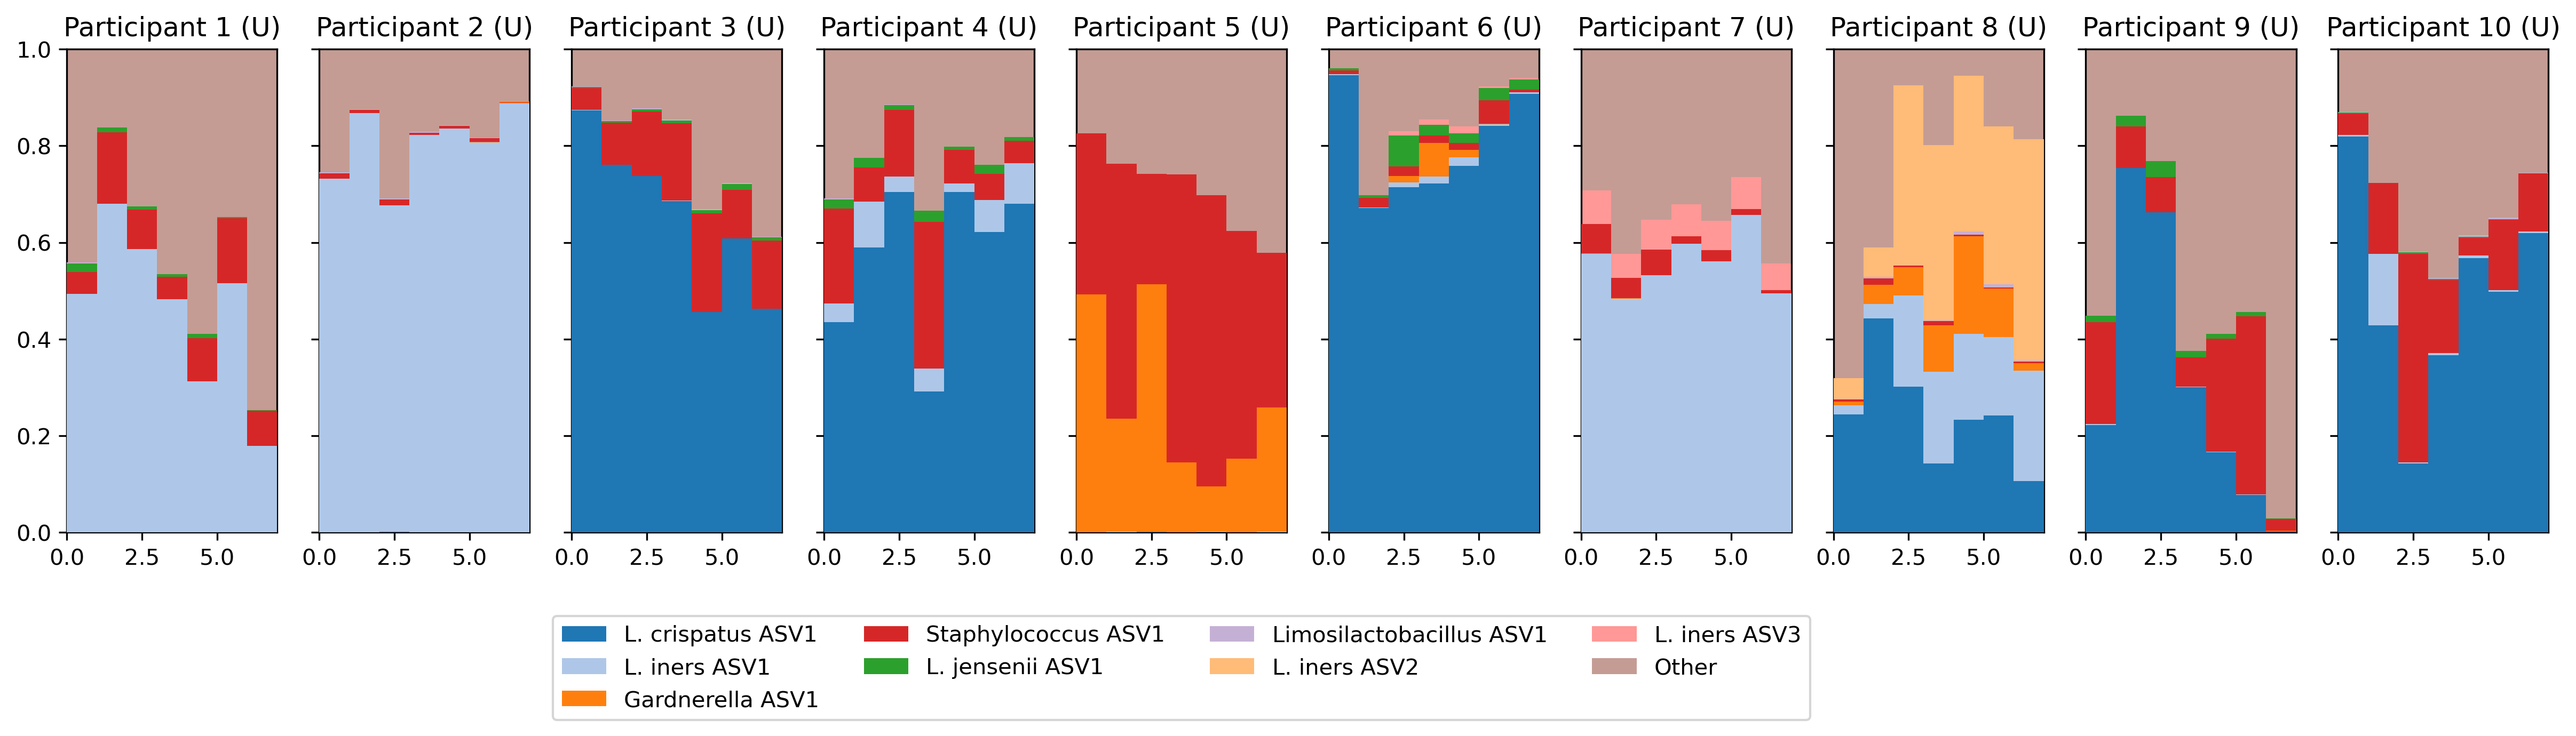

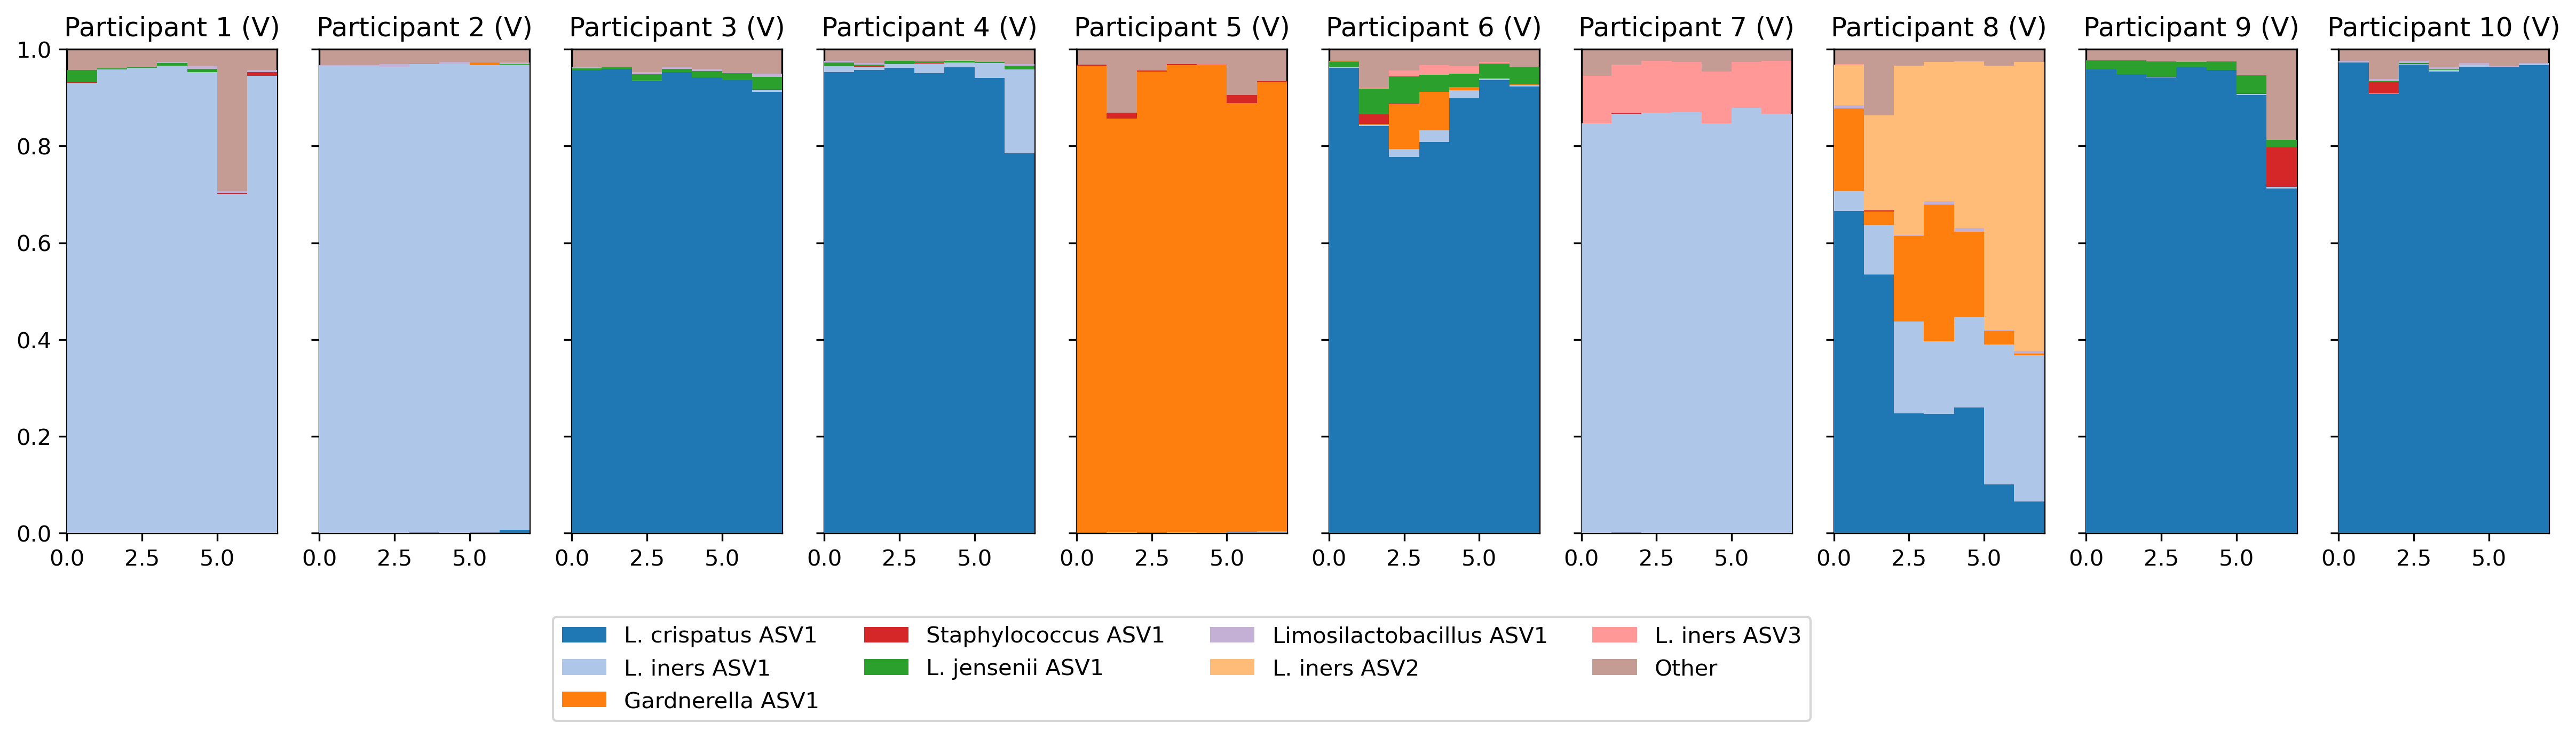

In [12]:
usamples = dict(S.reset_index().groupby(['condition','participant']).agg(list)[['Day','sample']].loc['Underwear'].apply(
lambda x: (int(x.name), [ y[1] for y in sorted(zip(x.Day, x['sample'])) ]), axis=1).values)

vsamples = dict(S.reset_index().groupby(['condition','participant']).agg(list)[['Day','sample']].loc['Vaginal FLOQSwab'].apply(
lambda x: (int(x.name), [ y[1] for y in sorted(zip(x.Day, x['sample'])) ]), axis=1).values)

selRA = RA.rename(columns=tlmap)[selected_taxa].rename(columns=selected_taxa)
selRA['Other'] = selRA.apply(lambda x: 1 - sum(x), axis=1)

fig, axes = biu.utils.figure.subplots(ncols=10, figsize=(20,4), sharey=True)
for i, p in enumerate(sorted(usamples)):
    s = usamples[p]
    biu.analysis.microbiome.plot.stacks(selRA.loc[s], reorder=False, ax=axes[i], legend=i==4,
                                        cmap=lambda x: selected_taxa_colors[selRA.columns[x]])
    axes[i].set_title('Participant %d (U)' % p)
#efor

fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_barcharts_underwear','svg'))

fig, axes = biu.utils.figure.subplots(ncols=10, figsize=(20,4), sharey=True)
for i, p in enumerate(sorted(vsamples)):
    s = vsamples[p]
    biu.analysis.microbiome.plot.stacks(selRA.loc[s], reorder=False, ax=axes[i], legend=i==4,
                                        cmap=lambda x: selected_taxa_colors[selRA.columns[x]])
    axes[i].set_title('Participant %d (V)' % p)
#efor

fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_barcharts_vaginal','svg'))


# Embeddings

## PCoA

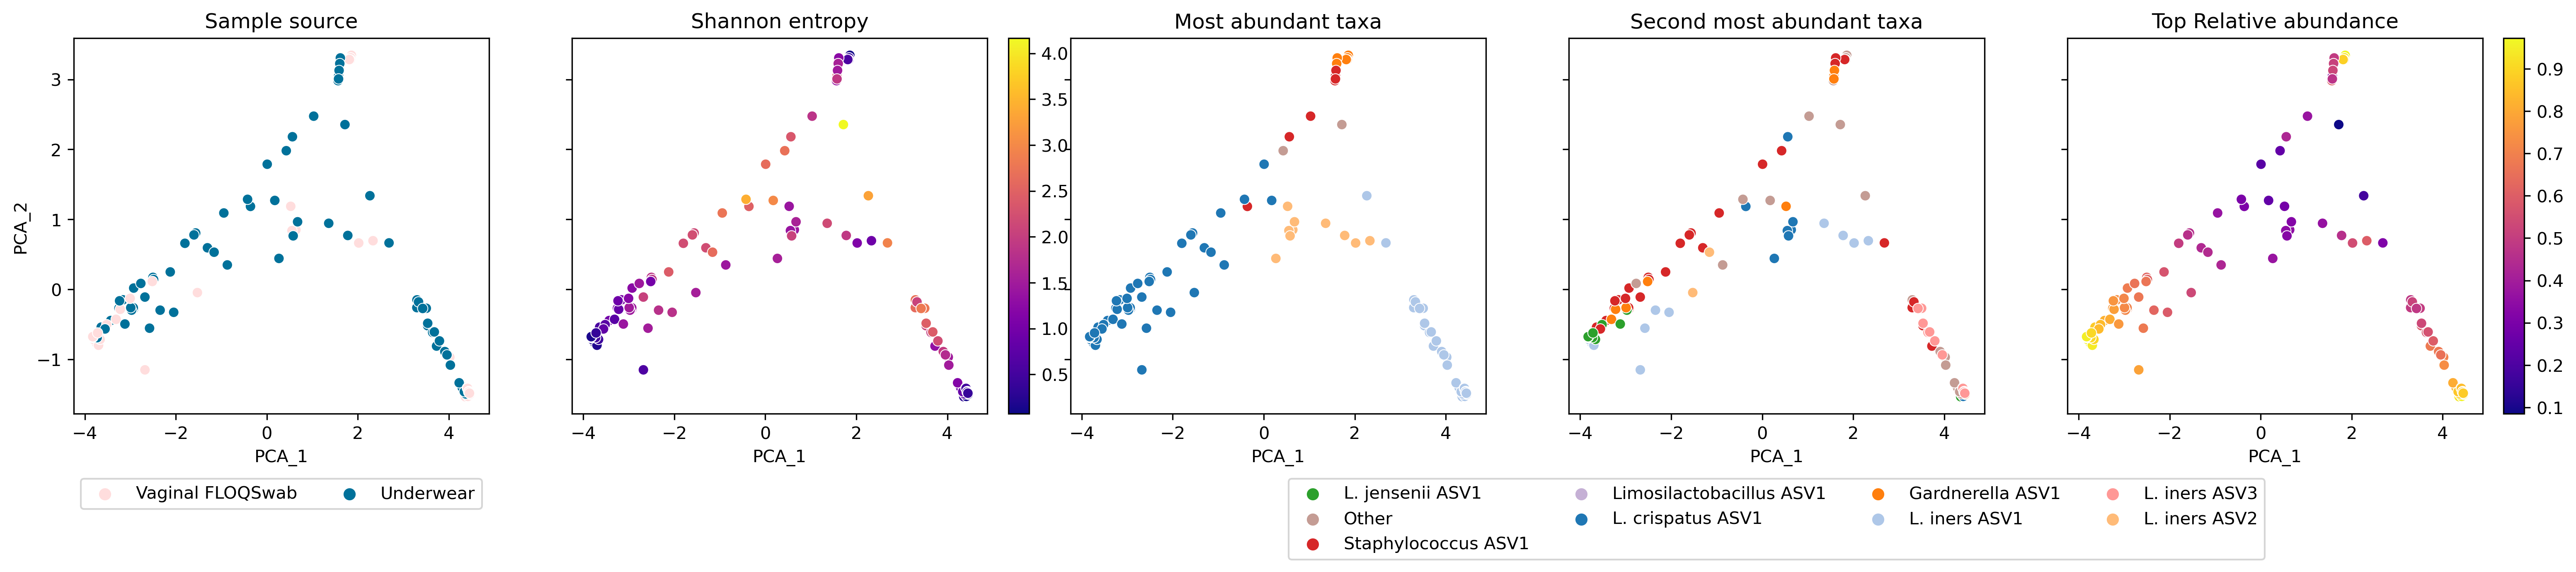

In [13]:
def move_colorbar(ax, data, width="5%", height="100%", loc='lower left'):
    norm = plt.Normalize(data.min(), data.max())
    sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    #fi
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    axins = inset_axes(ax,
           width=width,  # width = 5% of parent_bbox width
           height=height,  # height : 50%
           loc=loc,
           bbox_to_anchor=(1.05, 0., 1, 1),
           bbox_transform=ax.transAxes,
           borderpad=0,
           )
    ax.figure.colorbar(sm, cax=axins)
#edef

fig, axes = biu.utils.figure.subplots(ncols=5, figsize=(25,4), sharey=True)
sns.scatterplot(x="PCA_1", y="PCA_2", data=S, hue='condition', palette=[pink,blue], ax=axes[0])
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
axes[0].set_title('Sample source')

sns.scatterplot(x="PCA_1", y="PCA_2", data=S, hue='shannon', palette='plasma', ax=axes[1])
axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
move_colorbar(axes[1], S['shannon'])
axes[1].set_title('Shannon entropy')

sns.scatterplot(x="PCA_1", y="PCA_2", data=S, hue='genus1', palette=selected_taxa_colors, ax=axes[2])
axes[2].legend().remove()#loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
axes[2].set_title('Most abundant taxa')

sns.scatterplot(x="PCA_1", y="PCA_2", data=S, hue='genus2', palette=selected_taxa_colors, ax=axes[3])
axes[3].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
axes[3].set_title('Second most abundant taxa')

maxabundance=RA.max(axis=1)
sns.scatterplot(x="PCA_1", y="PCA_2", data=S, hue=maxabundance, palette='plasma', ax=axes[4])
move_colorbar(axes[4], maxabundance)
axes[4].set_title('Top Relative abundance')

fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_embedding_pcoa','svg'))

## tSNE

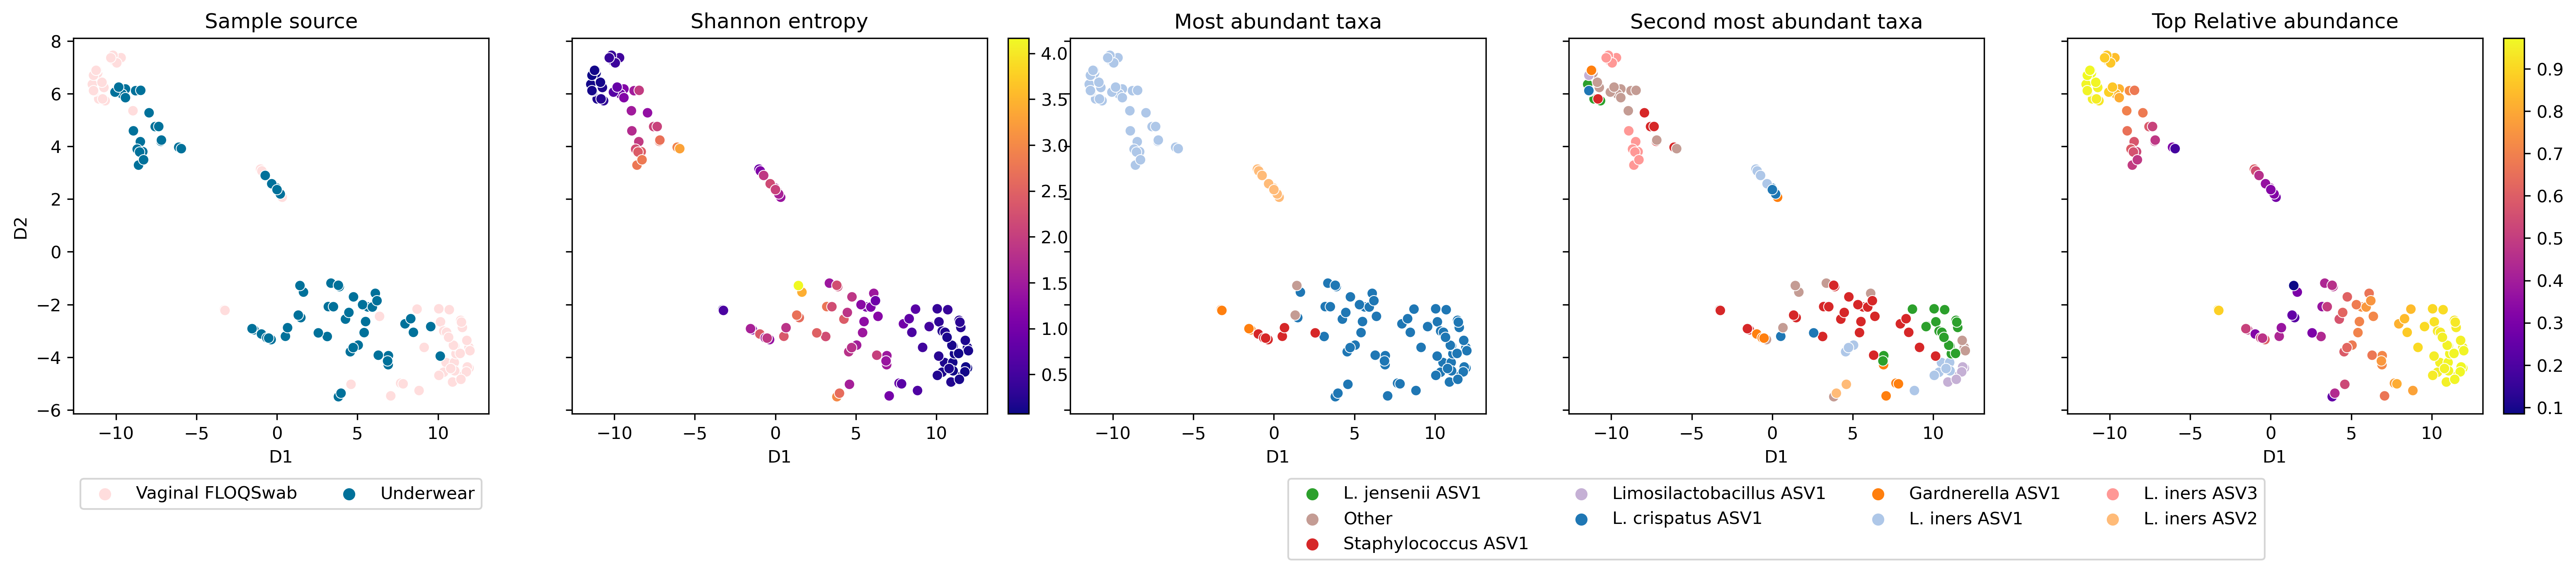

In [14]:
fig, axes = biu.utils.figure.subplots(ncols=5, figsize=(25,4), sharey=True)
sns.scatterplot(x="D1", y="D2", data=S, hue='condition', palette=[pink,blue], ax=axes[0])
axes[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
axes[0].set_title('Sample source')

sns.scatterplot(x="D1", y="D2", data=S, hue='shannon', palette='plasma', ax=axes[1])
axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
move_colorbar(axes[1], S['shannon'])
axes[1].set_title('Shannon entropy')

sns.scatterplot(x="D1", y="D2", data=S, hue='genus1', palette=selected_taxa_colors, ax=axes[2])
axes[2].legend().remove()#loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
axes[2].set_title('Most abundant taxa')

sns.scatterplot(x="D1", y="D2", data=S, hue='genus2', palette=selected_taxa_colors, ax=axes[3])
axes[3].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
axes[3].set_title('Second most abundant taxa')

maxabundance=RA.max(axis=1)
sns.scatterplot(x="D1", y="D2", data=S, hue=maxabundance, palette='plasma', ax=axes[4])
move_colorbar(axes[4], maxabundance)
axes[4].set_title('Top Relative abundance')

fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_embedding_tsne','svg'))

# Alpha diversity 

## Heatmap

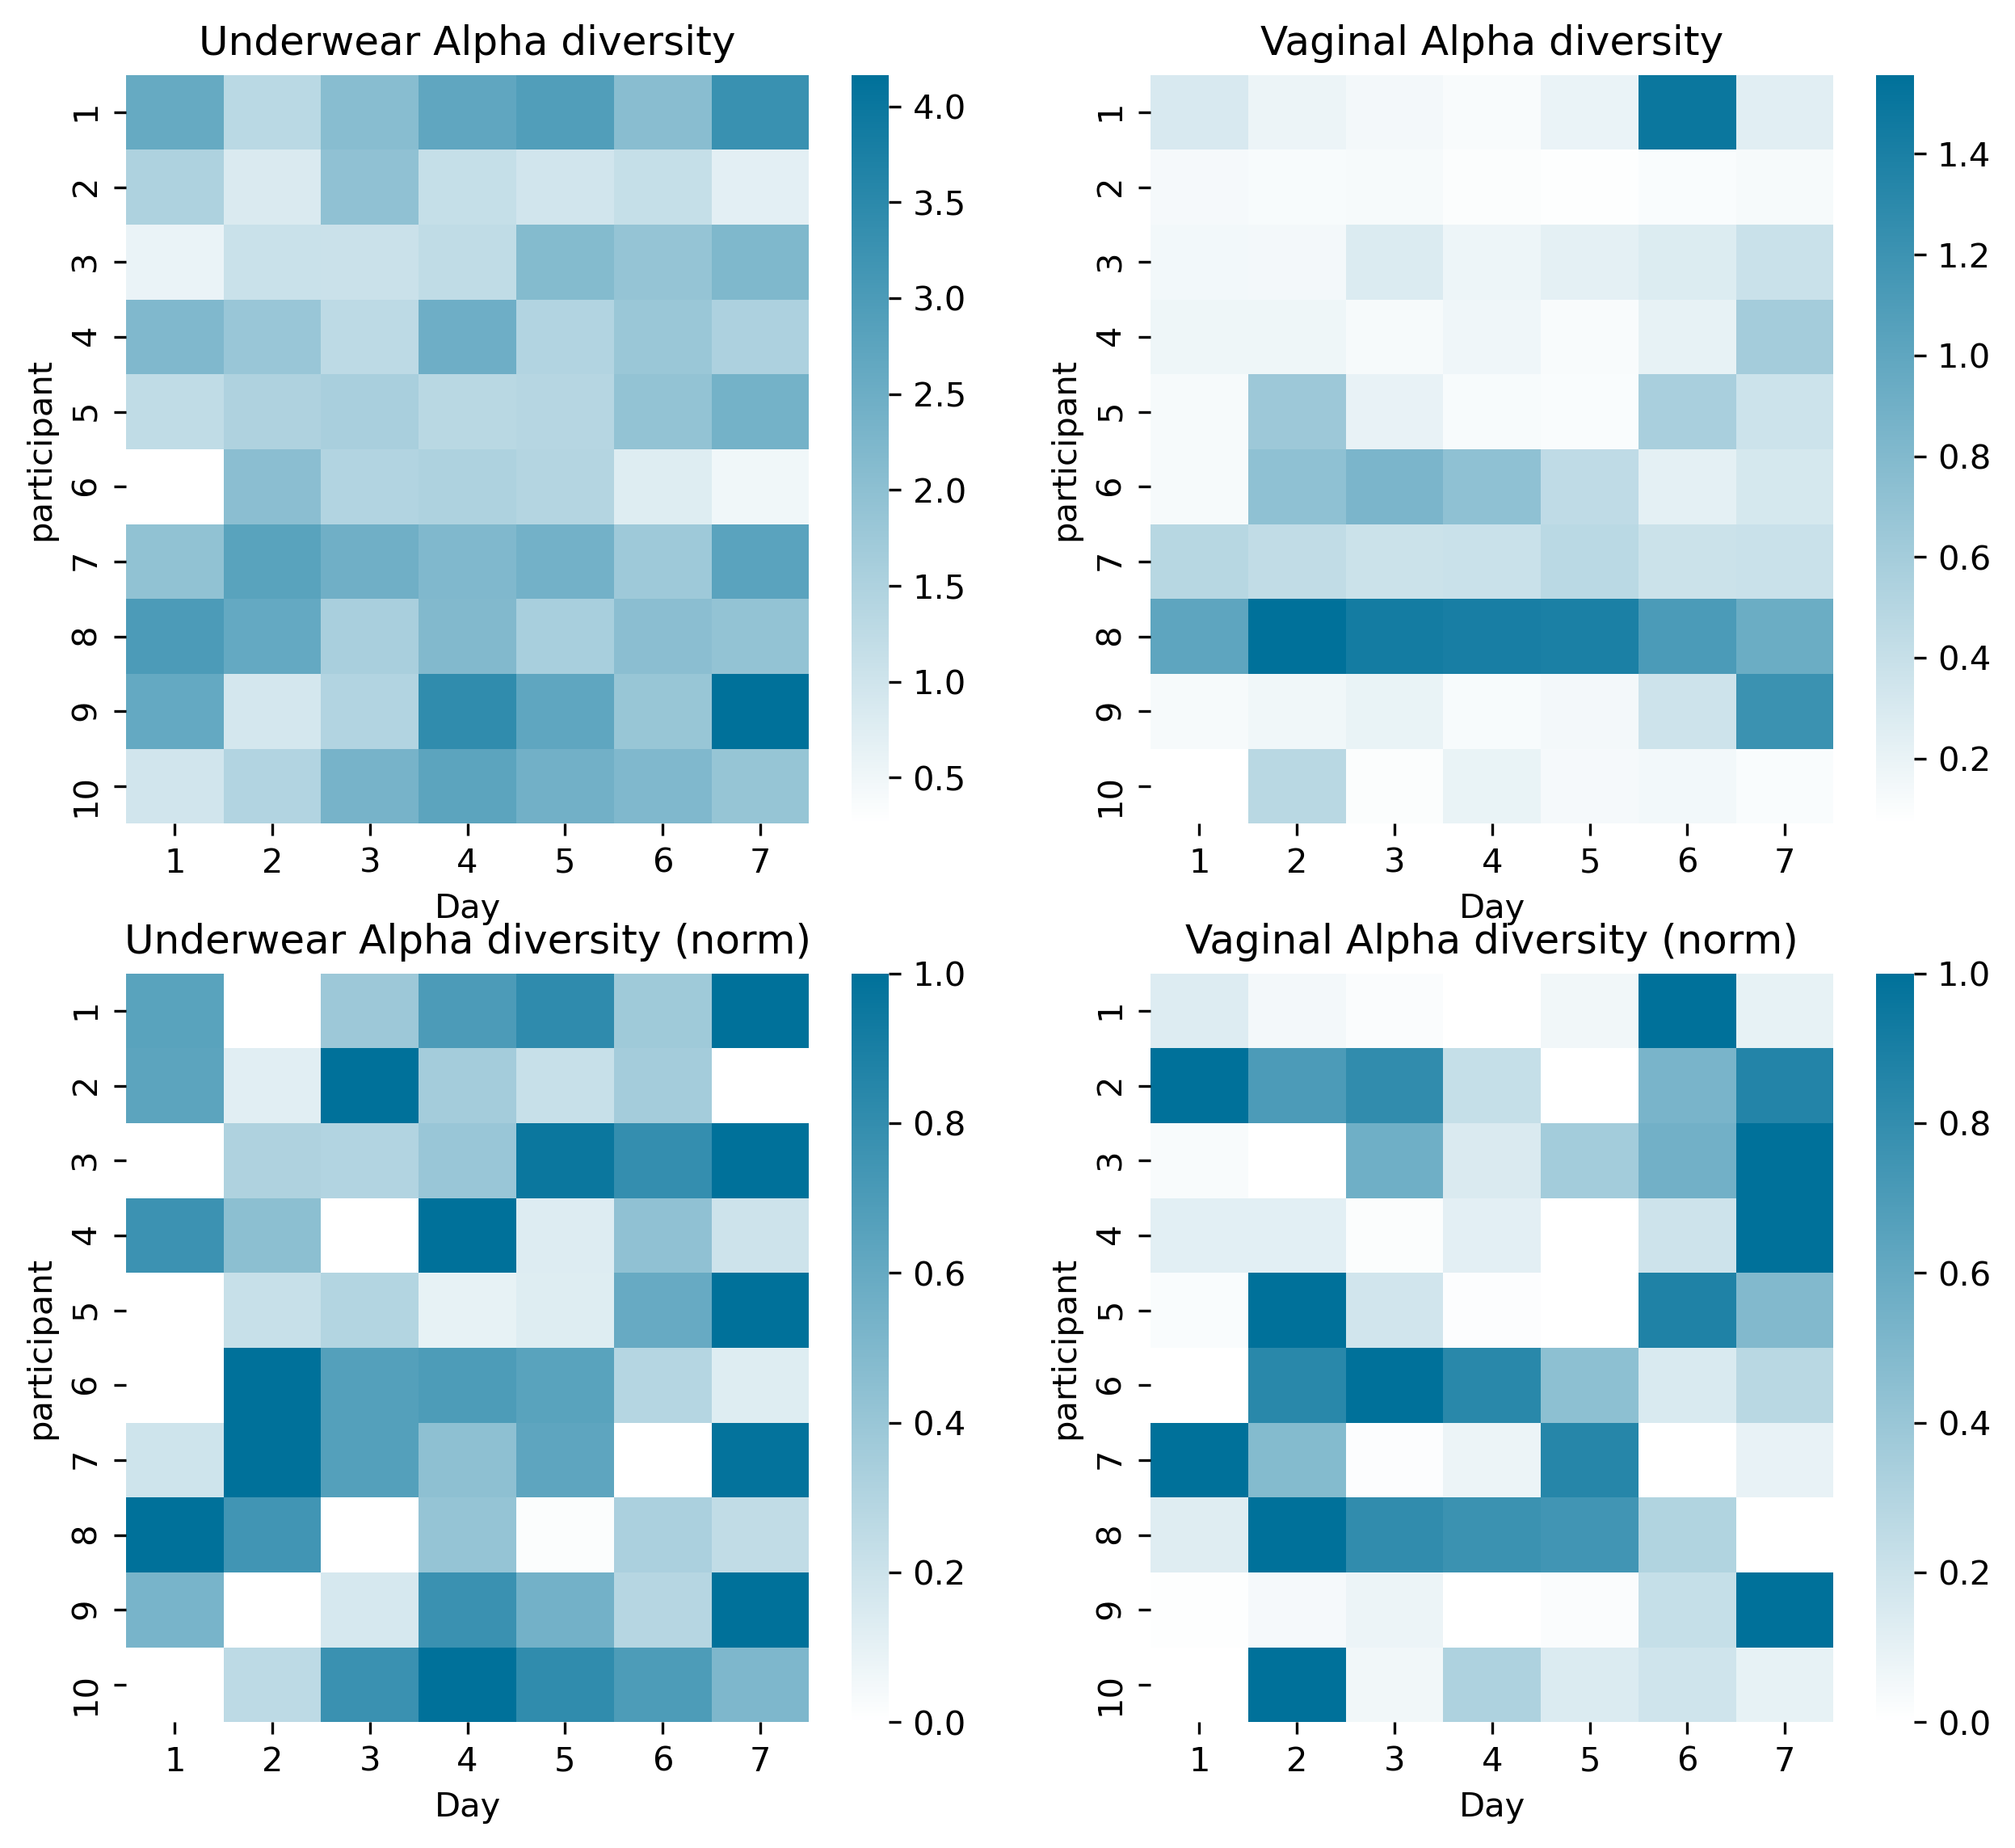

In [15]:
fig, axes = biu.utils.figure.subplots(figsize=(10,9), ncols=2, nrows=2)

alpha_pivot = S.pivot(index=['condition','participant'], columns='Day', values='shannon')
alpha_pivot_norm = alpha_pivot.apply(lambda x: (x - x[~pd.isna(x)].min()) / (x[~pd.isna(x)].max() - x[~pd.isna(x)].min()), axis=1)

sns.heatmap(alpha_pivot.loc['Underwear'], ax=axes[0], cmap=blue_cmap)
axes[0].set_title('Underwear Alpha diversity')

sns.heatmap(alpha_pivot.loc['Vaginal FLOQSwab'], ax=axes[1], cmap=blue_cmap)
axes[1].set_title('Vaginal Alpha diversity')

sns.heatmap(alpha_pivot_norm.loc['Underwear'], ax=axes[2], cmap=blue_cmap)
axes[2].set_title('Underwear Alpha diversity (norm)')

sns.heatmap(alpha_pivot_norm.loc['Vaginal FLOQSwab'], ax=axes[3], cmap=blue_cmap)
axes[3].set_title('Vaginal Alpha diversity (norm)')

fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_heatmap_alpha','svg'))

# Beta diversity

## To day before

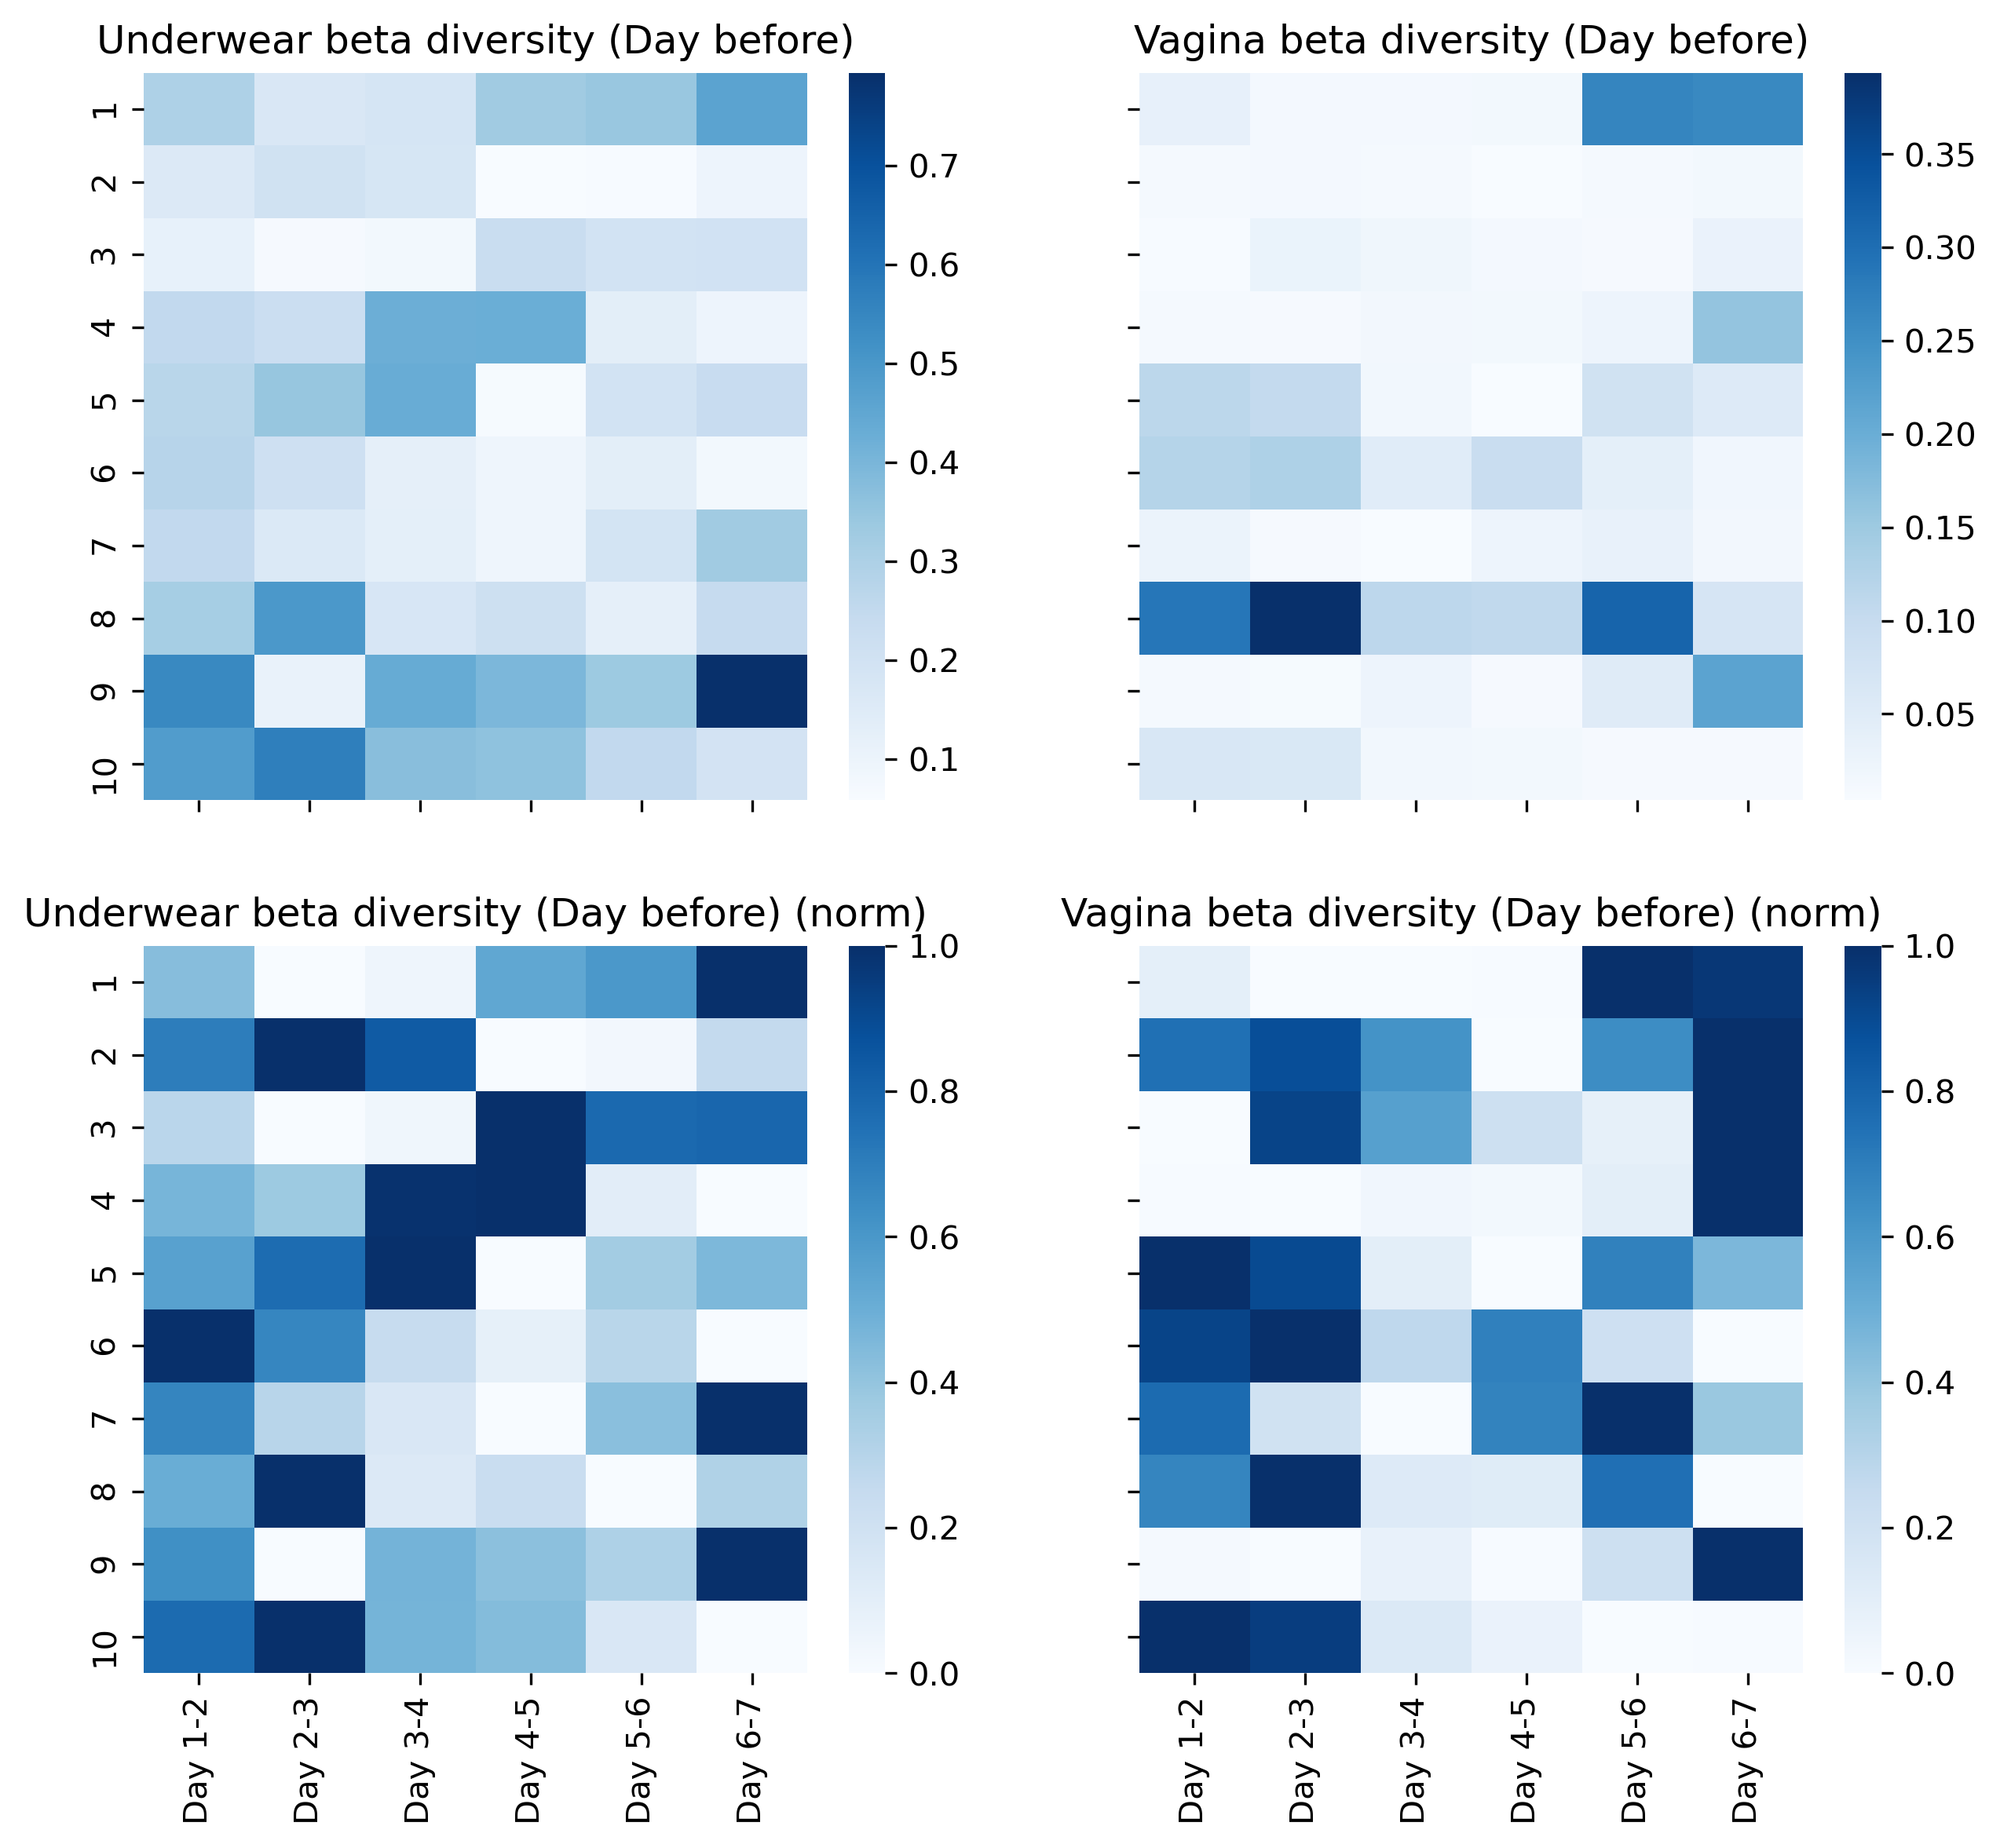

In [16]:
dists = pd.DataFrame(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(RA, metric='braycurtis')),
                     index=RA.index, columns=RA.index)

vbeta = { p : [ dists.loc[i][j] for i,j in zip(vsamples[p][:-1],vsamples[p][1:]) ] for p in vsamples }
vbeta = pd.DataFrame(vbeta, index=['Day %d-%d' % (i+1,i+2) for i in range(6)]).transpose()
vbeta_norm = vbeta.apply(lambda x: (x - x[~pd.isna(x)].min()) / (x[~pd.isna(x)].max() - x[~pd.isna(x)].min()), axis=1)

ubeta = { p : [ dists.loc[i][j] for i,j in zip(usamples[p][:-1],usamples[p][1:]) ] for p in vsamples }
ubeta = pd.DataFrame(ubeta, index=['Day %d-%d' % (i+1,i+2) for i in range(6)]).transpose()
ubeta_norm = ubeta.apply(lambda x: (x - x[~pd.isna(x)].min()) / (x[~pd.isna(x)].max() - x[~pd.isna(x)].min()), axis=1)

fig, axes = biu.utils.figure.subplots(figsize=(10,9), ncols=2, nrows=2, sharex=True, sharey=True)

sns.heatmap(ubeta, ax=axes[0], cmap='Blues')
axes[0].set_title('Underwear beta diversity (Day before)')

sns.heatmap(vbeta, ax=axes[1], cmap='Blues')
axes[1].set_title('Vagina beta diversity (Day before)')

sns.heatmap(ubeta_norm, ax=axes[2], cmap='Blues')
axes[2].set_title('Underwear beta diversity (Day before) (norm)')

sns.heatmap(vbeta_norm, ax=axes[3], cmap='Blues')
axes[3].set_title('Vagina beta diversity (Day before) (norm)')

fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_heatmap_beta','svg'))

In [17]:
import scipy

testdata = scipy.stats.zscore(biu.ops.lst.flatten(vbeta_norm[['Day 1-2','Day 4-5']].transpose().values))
#testdata
#vbeta_norm[['Day 1-2','Day 3-4']]
scipy.stats.ttest_rel(testdata[:10], testdata[10:])
scipy.stats.ttest_rel(vbeta_norm['Day 1-2'], vbeta_norm['Day 4-5'])
#vbeta_norm['Day 1-2']
#vbeta_norm['Day 1-2'] > vbeta_norm['Day 3-4']

Ttest_relResult(statistic=2.5075877126821955, pvalue=0.033442864130219234)

## To first day

Text(0.5, 1.0, 'Vagina beta diversity (First day) (norm)')

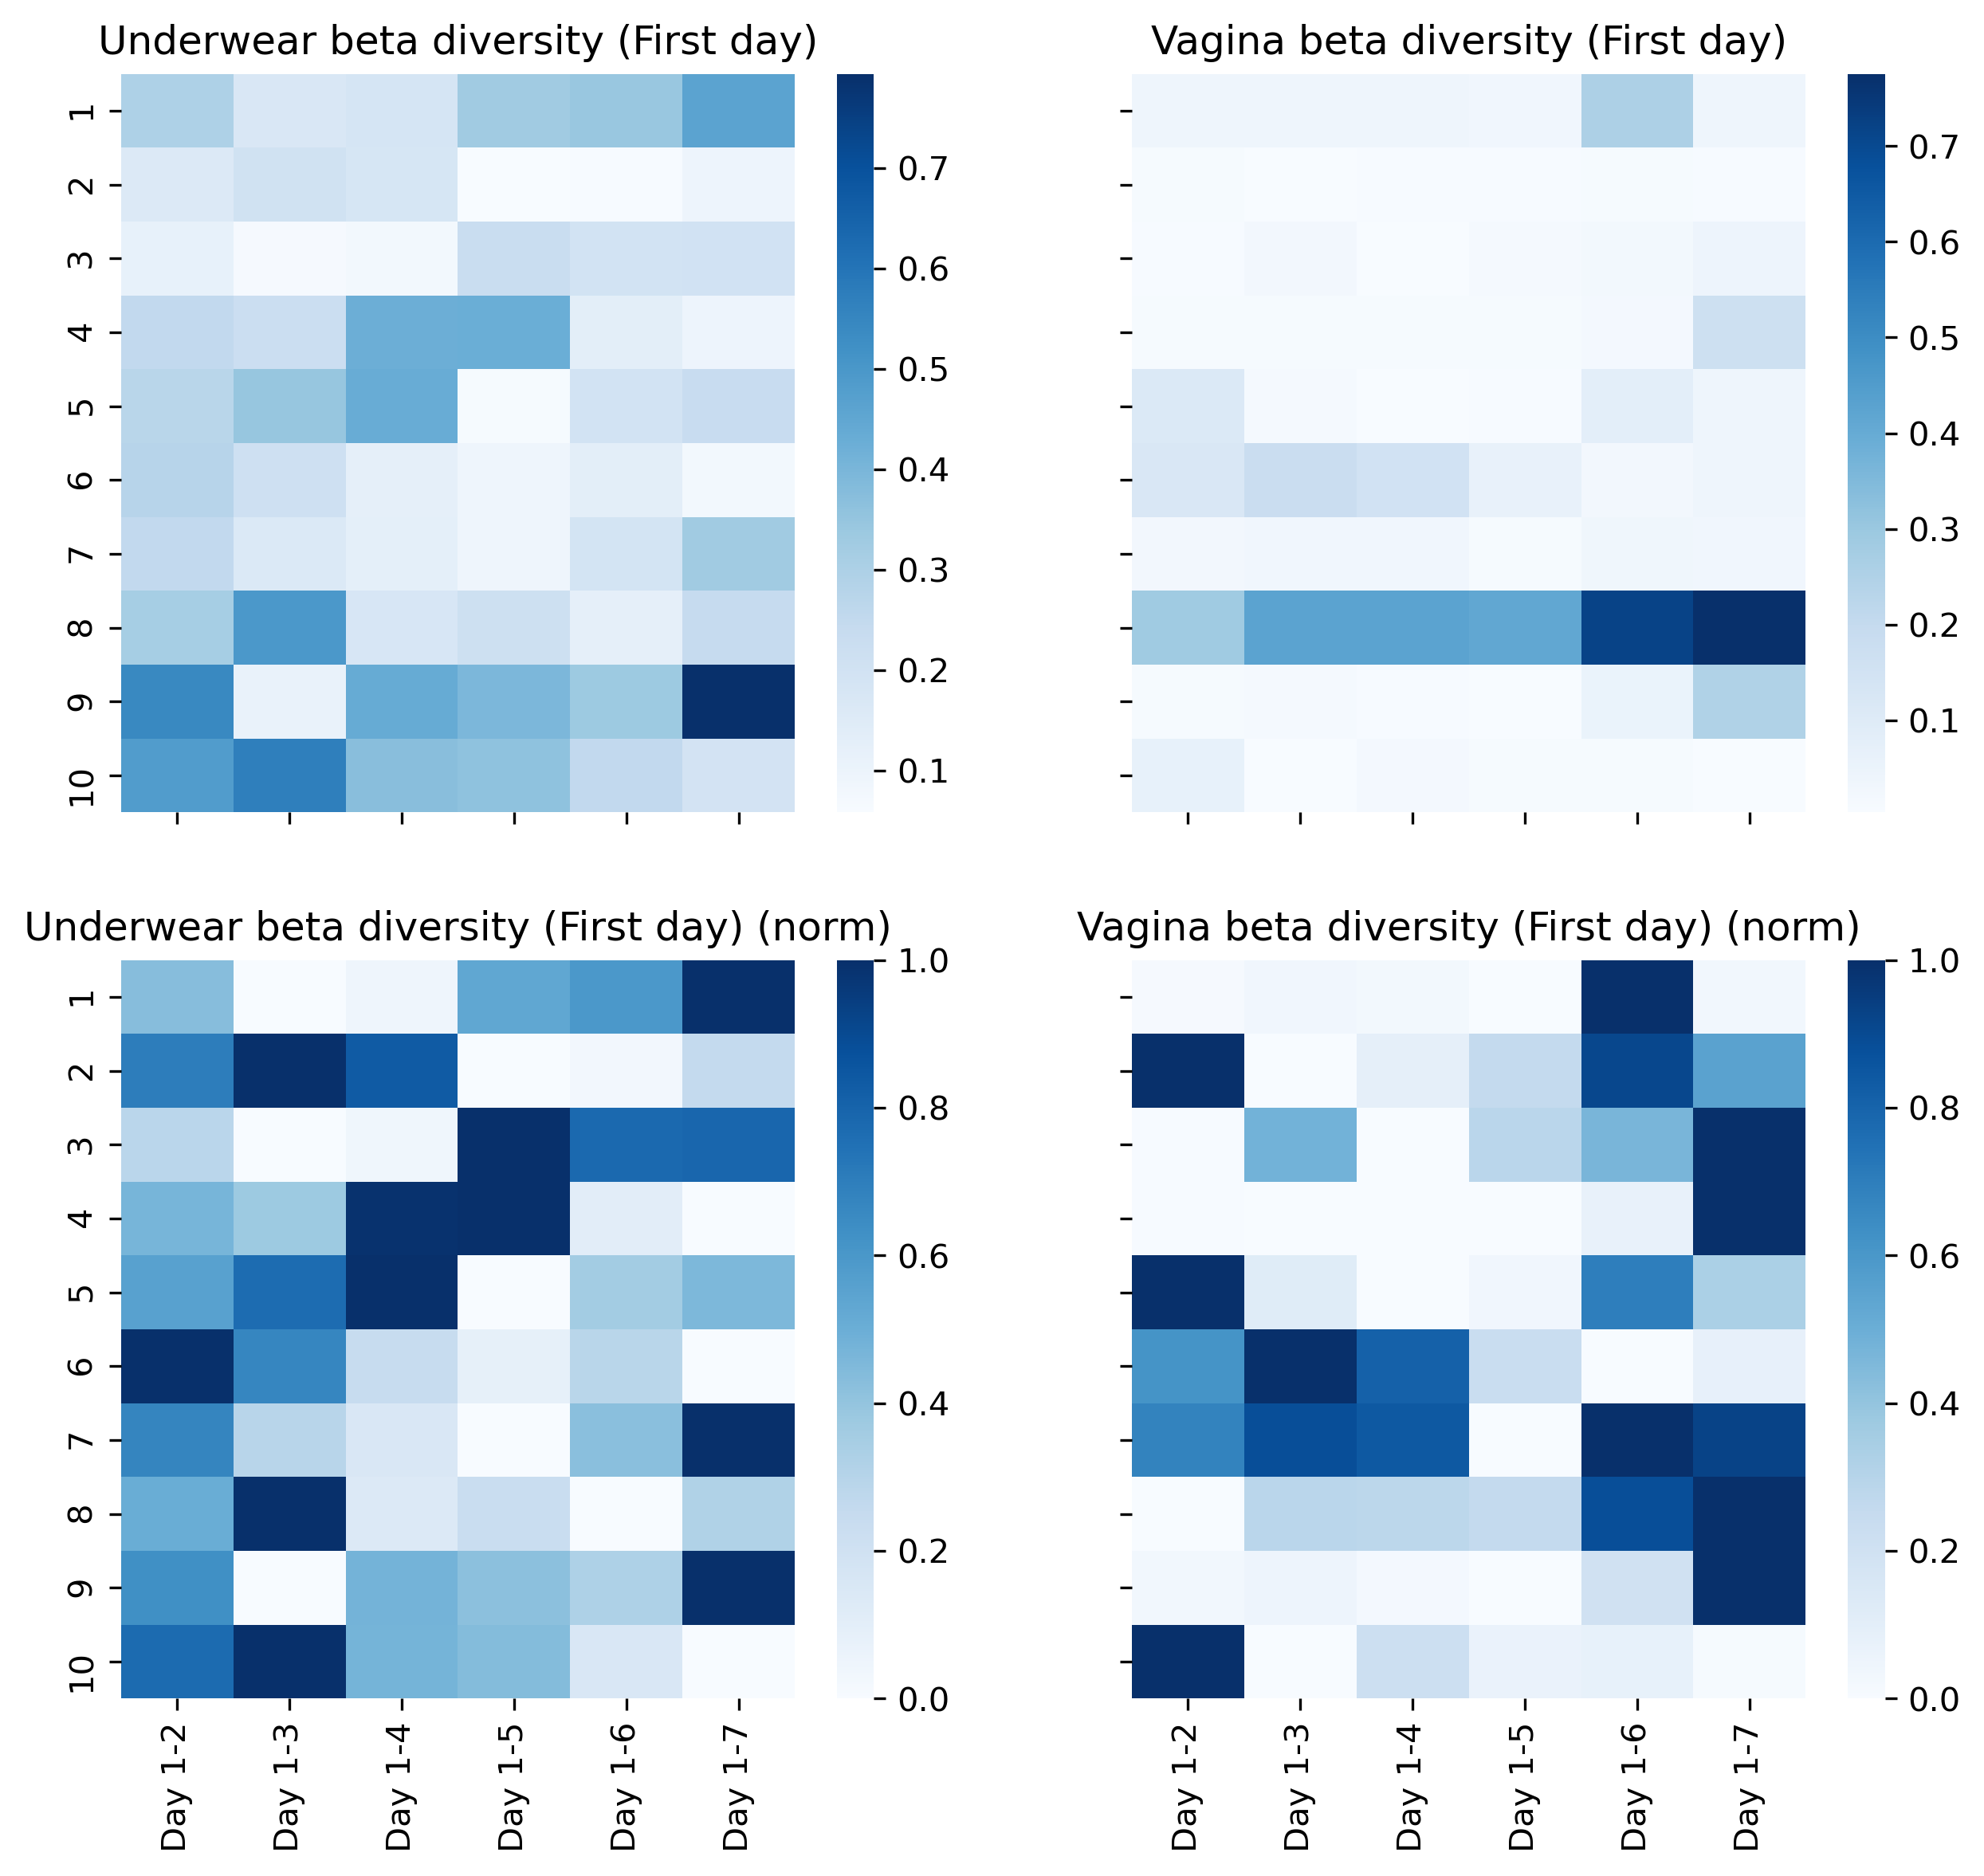

In [18]:
dists = pd.DataFrame(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(RA, metric='braycurtis')),
                     index=RA.index, columns=RA.index)

vbeta = { p : [ dists.loc[vsamples[p][0]][i] for i in vsamples[p][1:] ] for p in vsamples }
vbeta = pd.DataFrame(vbeta, index=['Day %d-%d' % (1,i+2) for i in range(6)]).transpose()
vbeta_norm = vbeta.apply(lambda x: (x - x[~pd.isna(x)].min()) / (x[~pd.isna(x)].max() - x[~pd.isna(x)].min()), axis=1)

ubeta = { p : [ dists.loc[i][j] for i,j in zip(usamples[p][:-1],usamples[p][1:]) ] for p in vsamples }
ubeta = pd.DataFrame(ubeta, index=['Day %d-%d' % (1,i+2) for i in range(6)]).transpose()
ubeta_norm = ubeta.apply(lambda x: (x - x[~pd.isna(x)].min()) / (x[~pd.isna(x)].max() - x[~pd.isna(x)].min()), axis=1)

fig, axes = biu.utils.figure.subplots(figsize=(10,9), ncols=2, nrows=2, sharex=True, sharey=True)

sns.heatmap(ubeta, ax=axes[0], cmap='Blues')
axes[0].set_title('Underwear beta diversity (First day)')

sns.heatmap(vbeta, ax=axes[1], cmap='Blues')
axes[1].set_title('Vagina beta diversity (First day)')

sns.heatmap(ubeta_norm, ax=axes[2], cmap='Blues')
axes[2].set_title('Underwear beta diversity (First day) (norm)')

sns.heatmap(vbeta_norm, ax=axes[3], cmap='Blues')
axes[3].set_title('Vagina beta diversity (First day) (norm)')

# Differential Relative abundance

Diff. ab. analysis is performed in `repos/UA_underwear/differential_abundance.ipynb`

## From MDA

In [19]:
mda_res = pd.read_csv("analysis/differential_abundance_mda.csv")

In [20]:
mda_res_suppl = mda_res.copy()
mda_res_suppl.taxa = mda_res_suppl.taxa.apply(lambda x: dict(zip(T.taxon_id, T.lname_id))[x])
mda_res_suppl.to_excel('analysis/differential_abundance_genedoe.xlsx')


In [21]:
nsig = mda_res.pivot_table(index="taxa", columns="variable", values="pvalue", aggfunc=lambda x: sum(x < 0.05)).transpose()
effectsize = mda_res[mda_res.method == 'maaslin2'].pivot_table(index="taxa", columns="variable", values='effectsize').transpose()

sel_factors = ['vaginal','vaginal_sex1','underwear_sex1']
sel_taxa = nsig.columns[((nsig.loc[sel_factors]) > 1).any()]

sel_taxa = sorted(sel_taxa, key=lambda t : 
                  dict(T.apply(lambda x: (x['taxon_id'],''.join(x[['kingdom','phylum','class','order','family','genus']].fillna('None'))), 
                               axis=1).values)[t])


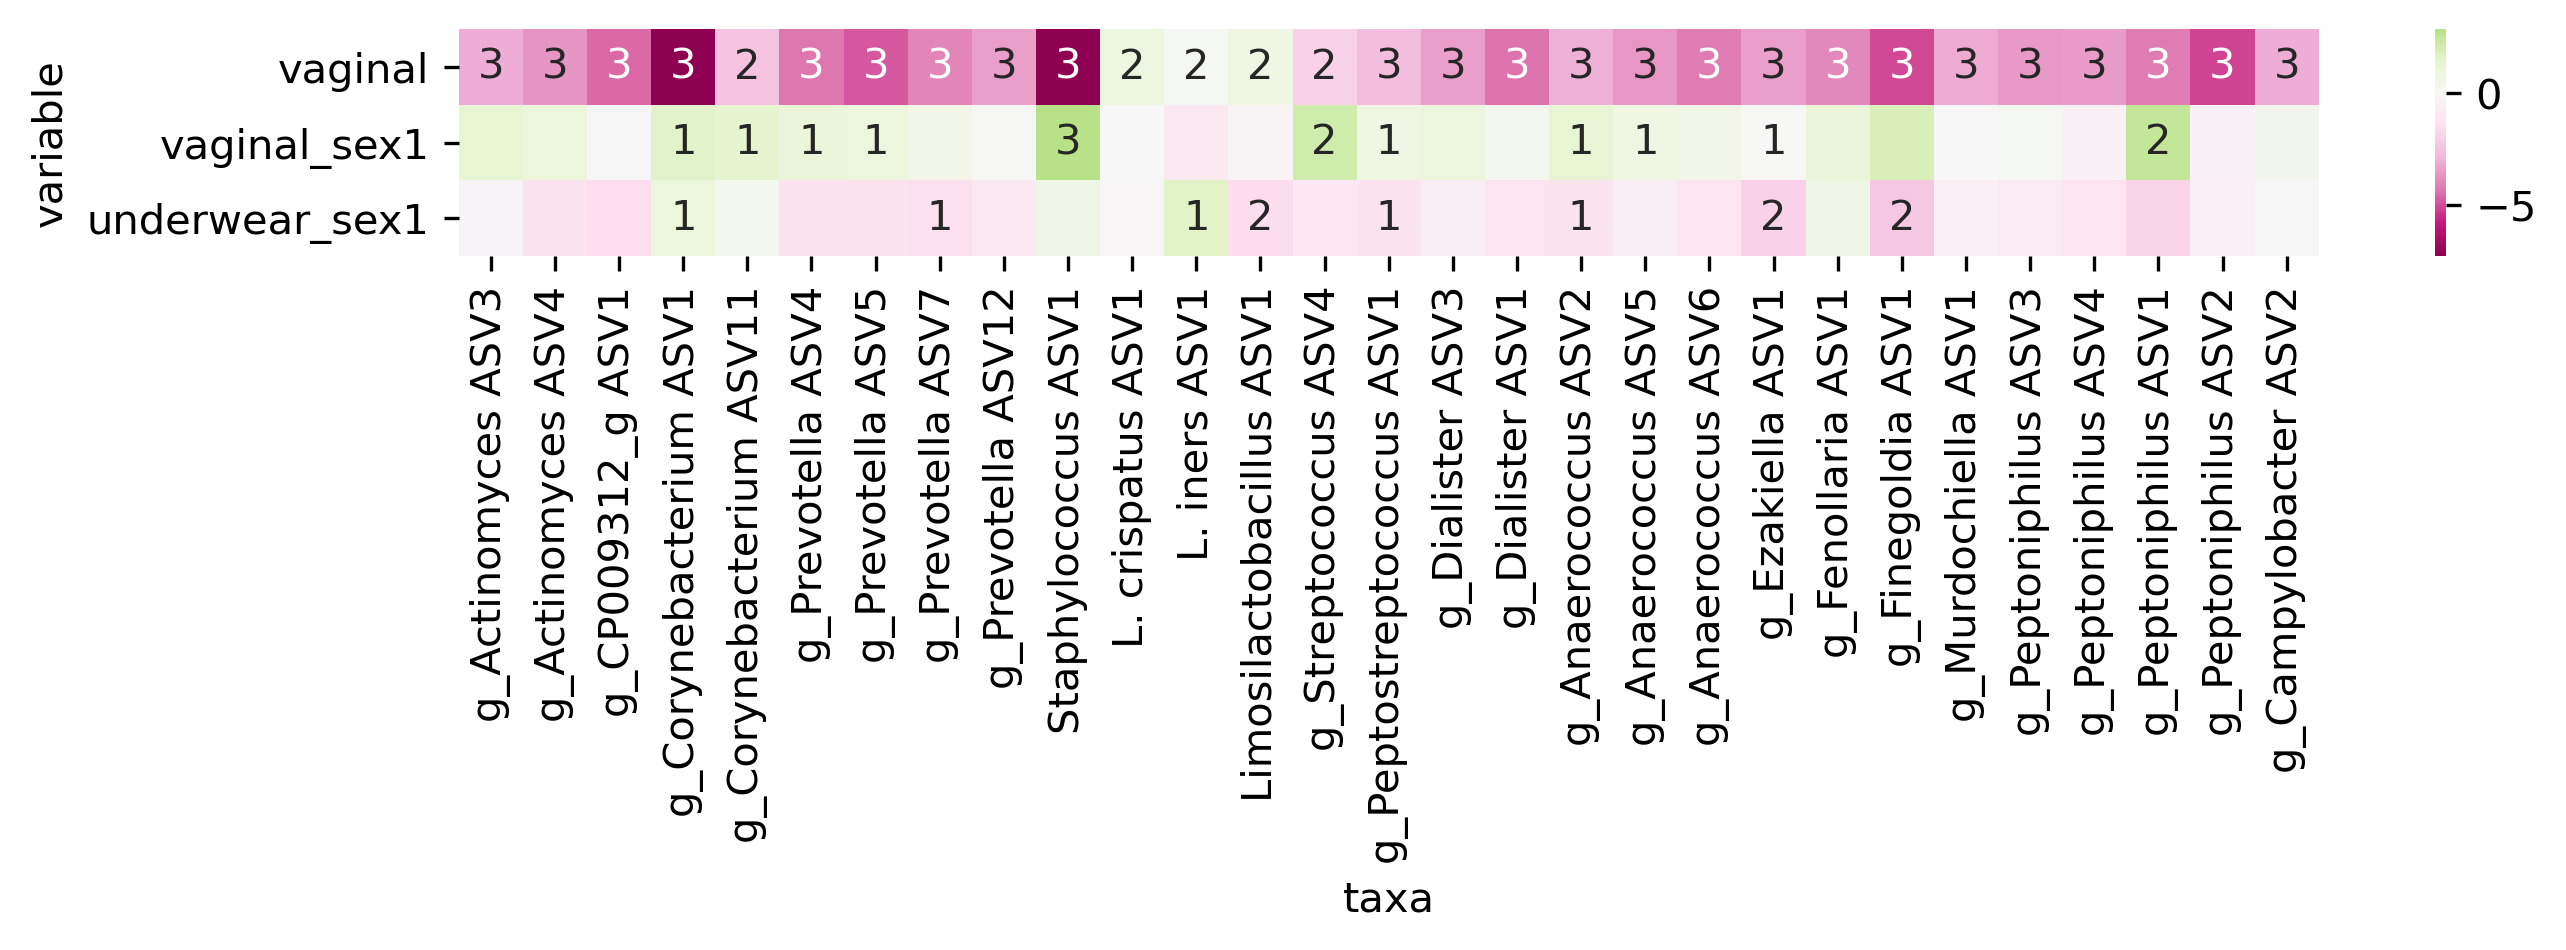

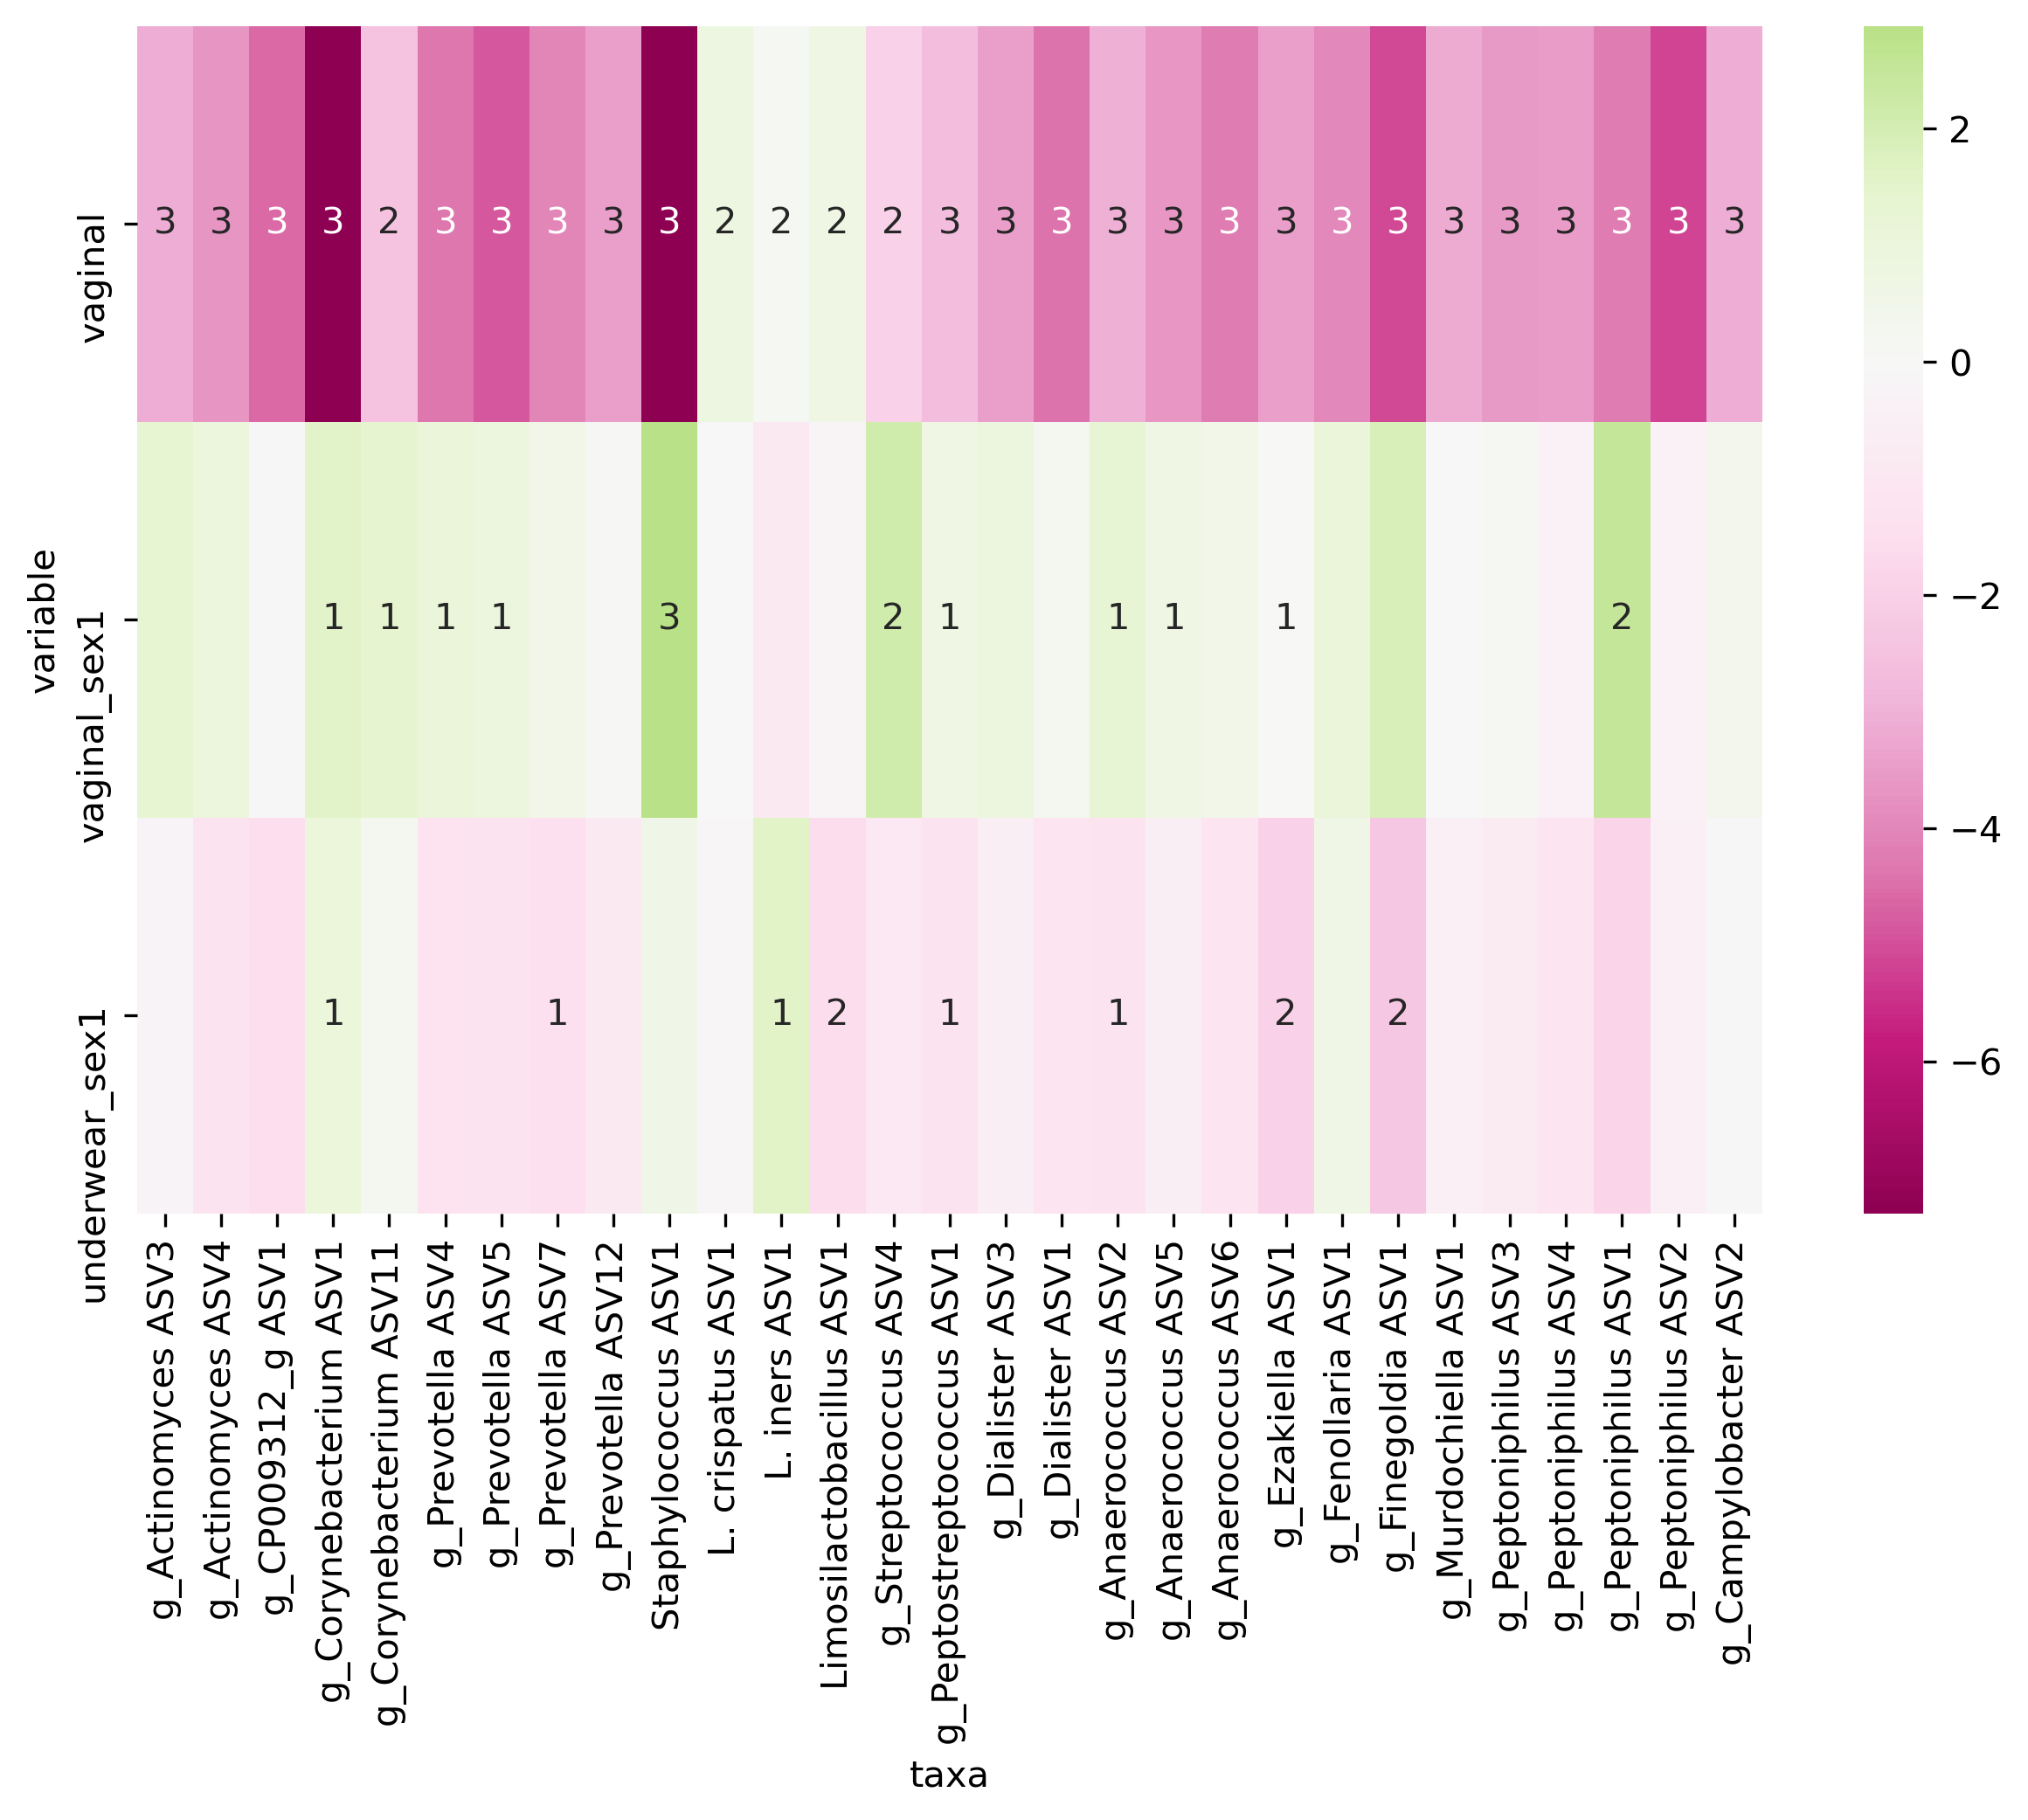

In [22]:
fig, axes = biu.utils.figure.subplots(figsize=(10,1))
sns.heatmap(effectsize.loc[sel_factors][sel_taxa].rename(columns=tlmap).rename(columns=selected_taxa), cmap='PiYG', fmt='s',center=0, 
            annot=nsig.loc[sel_factors][sel_taxa].applymap(lambda x: "%d" % x if x > 0 else ''))
fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_diffab_genedoe','svg'))

fig, axes = biu.utils.figure.subplots(figsize=(10,6))
sns.heatmap(effectsize.loc[sel_factors][sel_taxa].rename(columns=tlmap).rename(columns=selected_taxa), cmap='PiYG', fmt='s',center=0, 
            annot=nsig.loc[sel_factors][sel_taxa].applymap(lambda x: "%d" % x if x > 0 else ''))
fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_diffab_genedoe_higher','svg'))

## Plot CLR differences in specific taxa

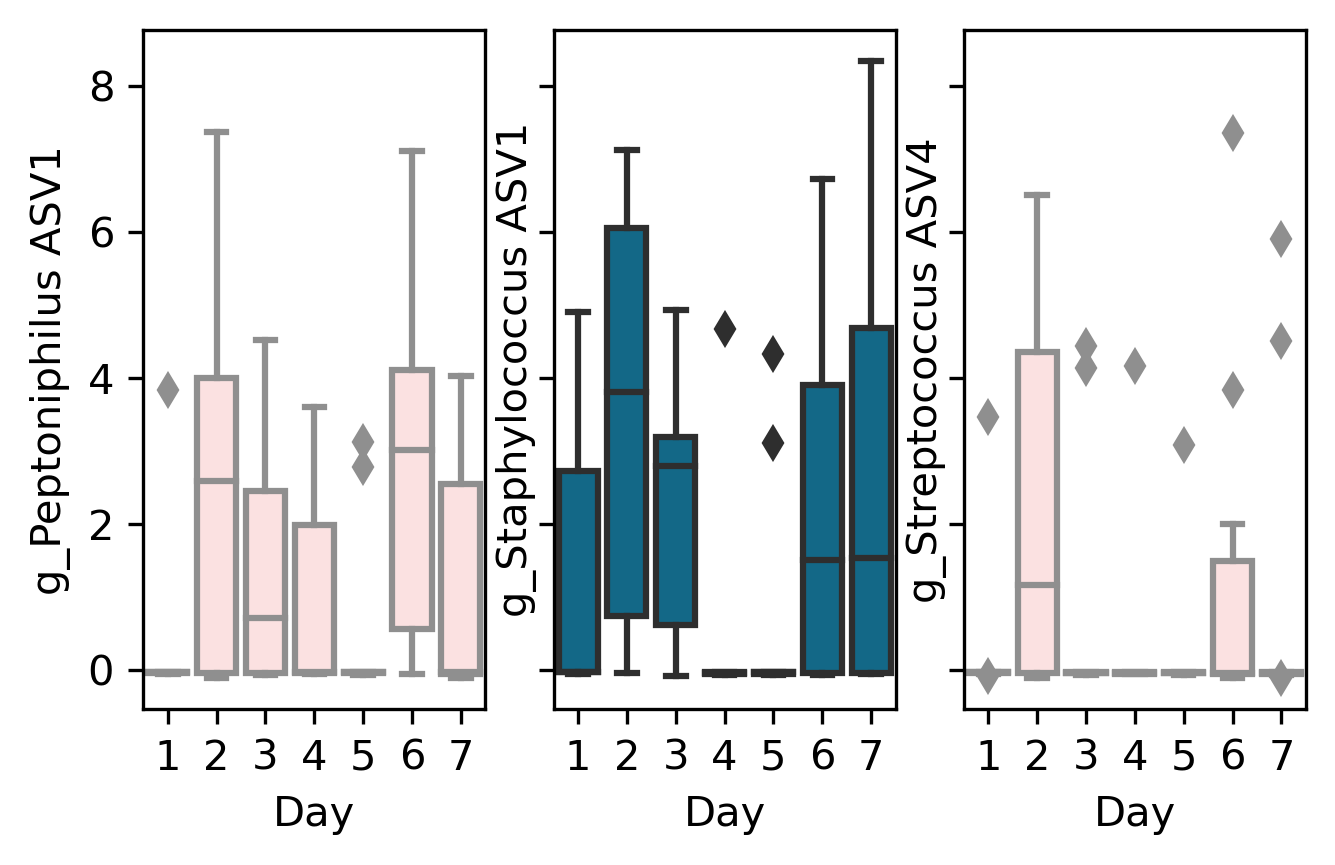

In [23]:
clr_sel = RA.apply(lambda x: np.log(x) - np.log(scipy.stats.gmean(x)), axis=1).rename(columns=tlmap)[
    ['g_Peptoniphilus ASV1','g_Streptococcus ASV4','g_Staphylococcus ASV1']]

clr_sel = clr_sel.join(S[['condition','Day']])
clr_sel = clr_sel[(clr_sel.condition == 'Vaginal FLOQSwab') & clr_sel.Day.isin([1,2,3,4,5,6,7])]
clr_sel.Day = clr_sel.Day.astype('category')

fig, axes = biu.utils.figure.subplots(figsize=(5,3), ncols=3, sharey=True)
sns.boxplot(x='Day', y='g_Peptoniphilus ASV1',  data=clr_sel, palette=[pink], ax=axes[0])
sns.boxplot(x='Day', y='g_Staphylococcus ASV1', data=clr_sel, palette=[blue], ax=axes[1])
sns.boxplot(x='Day', y='g_Streptococcus ASV4',  data=clr_sel, palette=[pink], ax=axes[2])
#clr_sel.melt(id_vars=[''])
#clr_sel
fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_clr_genedoe','svg'))

## Look at diff. abundance in isala

In [24]:
I = biu.db.ISALA2()
isala_tgmap = dict(zip(I.rds_TG.taxon_id, I.rds_TG.genus))

mda_isala = pd.read_csv('/home/thies/repos/UA_isala/flow1_redo_revision/differentialabundance.mda/results.tsv', sep='\t')
mda_isala.taxa = mda_isala.taxa.apply(lambda x: isala_tgmap[x])
mda_isala_nsig = mda_isala.pivot_table(index="taxa", columns="variable", values="pvalue", aggfunc=lambda x: sum(x < 0.05)).rename(columns=dict())
mda_isala_effectsize = mda_isala[mda_isala.method == 'maaslin2'].pivot_table(index="taxa", columns="variable", values='effectsize')

In [25]:

sel_isala_vars = [
 'Sexual.Intercourse.24hours',
 'Sexual.Intercourse.frequency',
 'Sexual.partner.man',
 'Sexual.partners.monogamous',
 'Sexual.partners.multiple',
]

mda_isala_nsig_sel = mda_isala_nsig[mda_isala_nsig[ 'Sexual.Intercourse.24hours'] >= 1][sel_isala_vars]
mda_isala_effectsize_sel = mda_isala_effectsize.loc[mda_isala_nsig_sel.index][mda_isala_nsig_sel.columns]

mda_isala_nsig_sel = mda_isala_nsig_sel.transpose()
mda_isala_effectsize_sel = mda_isala_effectsize_sel.transpose()

isala_taxa_order = sorted(mda_isala_effectsize_sel.columns, key=lambda x: dict(I.rds_TG[['genus', 'sequence']].values)[x])

mda_isala_effectsize_sel = mda_isala_effectsize_sel[isala_taxa_order]
mda_isala_nsig_sel = mda_isala_nsig_sel[isala_taxa_order]

manually_selected_taxa = [
       'Actinomyces', 'Gardnerella', 'Bifidobacterium',
       'Corynebacterium', 'Atopobium',
       'Gemella', 'Staphylococcus', 'Aerococcus', 'Facklamia', 
       'Lactobacillus crispatus group', 'Lactobacillus gasseri group', 'Lactobacillus iners group', 'Lactobacillus jensenii group', 'Limosilactobacillus',
       'Streptococcus', 'Clostridium', 'Howardella', 'Moryella', 'Megasphaera',
       'Veillonella', 'Anaerococcus', 'Ezakiella',
       'Parvimonas', 'Peptoniphilus', 'Sneathia', 'Ureaplasma']

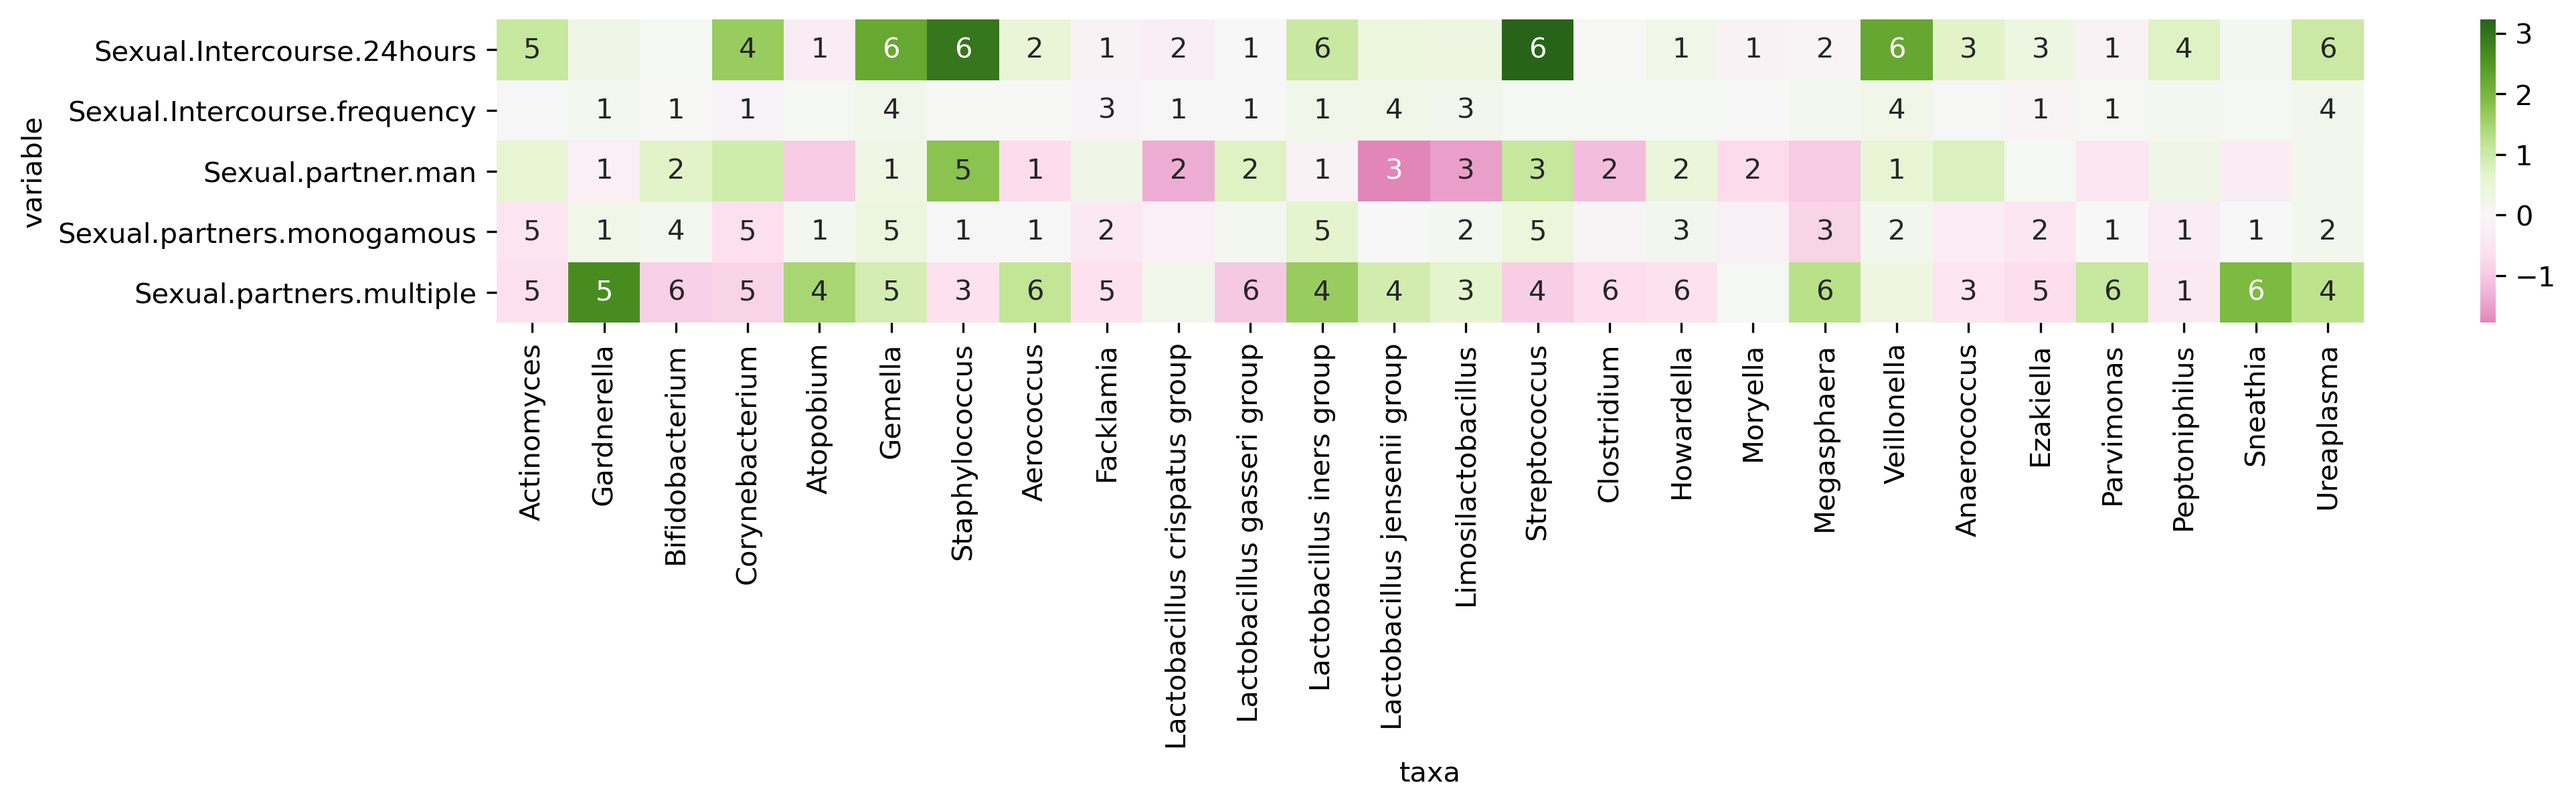

In [26]:
fig, axes = biu.utils.figure.subplots(figsize=(15,2))
sns.heatmap(mda_isala_effectsize[sel_isala_vars].loc[manually_selected_taxa].transpose(), cmap='PiYG', fmt='s', center=0,
            annot=mda_isala_nsig[sel_isala_vars].loc[manually_selected_taxa].transpose().applymap(lambda x: "%d" % x if x > 0 else ''))
fig.savefig(biu.utils.fs.filename_today('paper_figures/diffab_isala_mda','svg'))

### Alpha

5 1.425


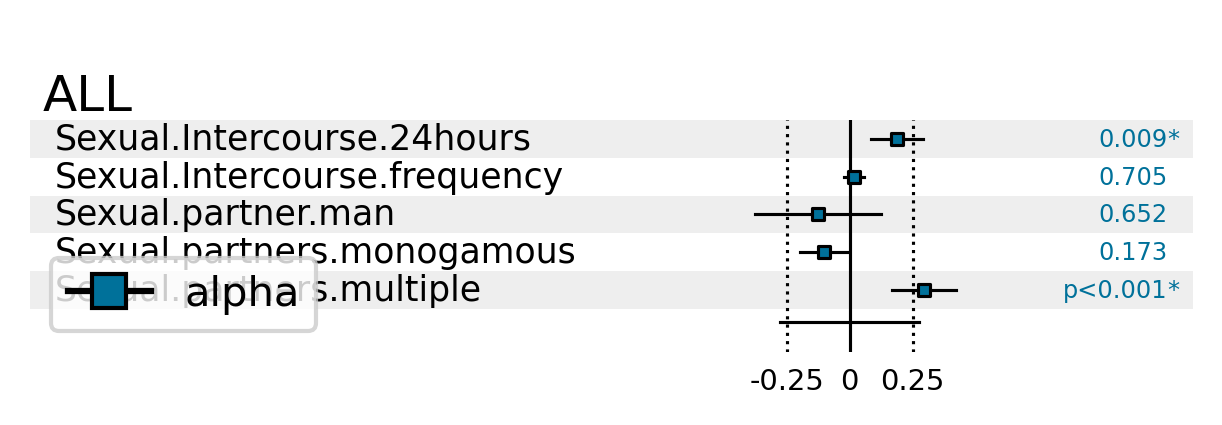

In [27]:
Ralpha = pd.read_csv('/mnt/a-samsung-mz7lm480-ssd/thies/repos/UA_isala/flow1_redo_revision/differentialabundance.alpha/results.tsv', sep='\t')

X = biu.analysis.metabolomics.forest(
    test_groups={"all":sel_isala_vars},
    tests=Ralpha,
    col_effect="effectsize",
    col_std="se",
    col_qvalue='qvalue',
    col_test='variable',
    col_condition='method', ticks=[-0.25,0,0.25],
    test_left_offset=3,
    condition_colors=[ blue ],
    condition_markers=['s' for i in range(10)] )
X.savefig(biu.utils.fs.filename_today('paper_figures/diffab_isala_alpha','svg'))

### Beta

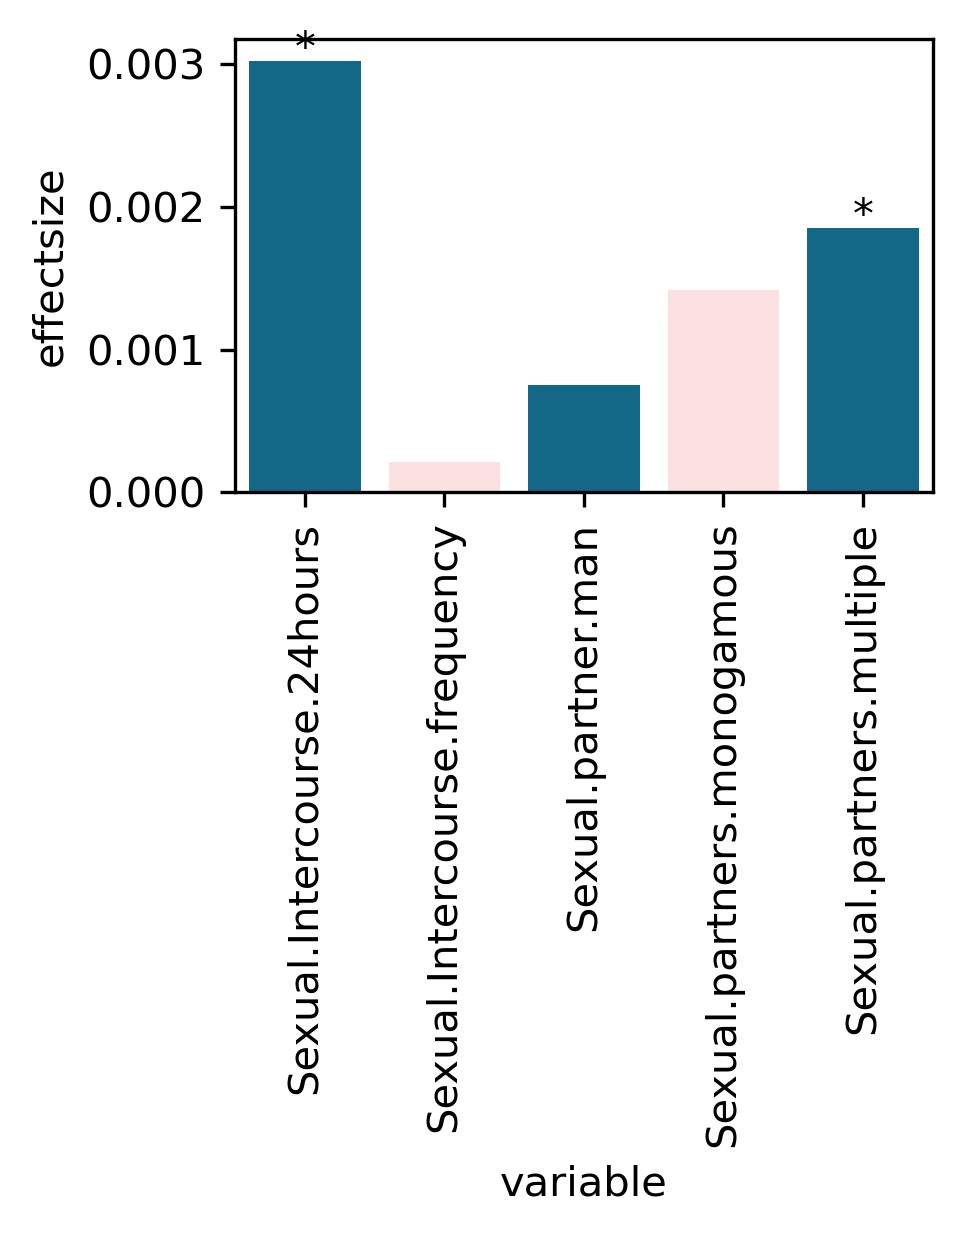

In [28]:
Rbeta = pd.read_csv('/mnt/a-samsung-mz7lm480-ssd/thies/repos/UA_isala/flow1_redo_revision/differentialabundance.beta.joined.tsv',sep='\t')

fig, axes = biu.utils.figure.subplots(figsize=(3,2))
X = sns.barplot(x='variable', y='effectsize', palette=[blue,pink], data=Rbeta.set_index('variable').loc[sel_isala_vars].reset_index(), ax=axes[0])
_ = plt.xticks(rotation=90)

for t in X.xaxis.get_ticklabels():
    x, y = t.get_position()
    var = t.get_text()
    r = Rbeta[(Rbeta.variable == var)]
    if r.shape[0] < 1:
        continue
    else:
        r = r.iloc[0]
    #fi
    if r.qvalue <= 0.05:
        plt.text(x, r.effectsize, '*', ha='center')
    #fi
    #efor
#efor
fig.savefig(biu.utils.fs.filename_today('paper_figures/diffab_isala_beta','svg'))

# Predict sex yes/no

In [29]:
R = biu.R()
def lopo(x, y, data, person_col):
    ppl = set(data[person_col])
    Res = {}
    Mod = {}
    T = []
    for person in ppl:
        test =  data[data[person_col] == person]
        train = data[data[person_col] != person]
        
        R.push(x=x, y=y, trainx=train[x], trainy=train[y], testx=test[x], testy=test[y])
        t = R("""
            library('glmnet')
            m <- cv.glmnet(as.matrix(trainx), family='binomial', trainy, alpha=0.5)
            t <- predict(m, as.matrix(testx), s=m$lambda.min, type='response')
            as.data.frame(t)
        """)
        print(t.join(test[y]))
        T.append(t.join(test[y]))
    #efor
    
    return pd.concat(T)
#efor

## Delta model

### Vagina

In [30]:
RA_clr = RA.apply(lambda x: np.log(x) - np.log(scipy.stats.gmean(x)), axis=1)
S_vsex = S[(S.condition == 'Vaginal FLOQSwab') & S.Day.isin([1,2,4,5])]
DV = pd.concat([
    pd.DataFrame([ [p,'Sex'] + list((RA_clr.loc[s[2]] - RA_clr.loc[s[1]]).values)
     for (p, s) in S_vsex.reset_index().pivot(index='participant',columns='Day', values='sample').iterrows()]),
    pd.DataFrame([ [p,'No Sex'] + list((RA_clr.loc[s[5]] - RA_clr.loc[s[4]]).values)
     for (p, s) in S_vsex.reset_index().pivot(index='participant',columns='Day', values='sample').iterrows()])])


DV.columns = ['participant','experiment'] + list(RA.columns)
DV.index   = [ 'CLRS_%d' % (i+1) for i in range(len(DV.index)) ]

DVP = lopo(list(RA.columns), 'experiment', DV, 'participant')

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Loaded glmnet 4.1-1



                1 experiment
CLRS_1   0.379587        Sex
CLRS_11  0.530556     No Sex
                1 experiment
CLRS_2   0.217783        Sex
CLRS_12  0.268474     No Sex
                1 experiment
CLRS_3   0.443479        Sex
CLRS_13  0.360572     No Sex
                1 experiment
CLRS_4   0.423870        Sex
CLRS_14  0.577853     No Sex
                1 experiment
CLRS_5   0.631257        Sex
CLRS_15  0.403252     No Sex
                1 experiment
CLRS_6   0.763802        Sex
CLRS_16  0.427981     No Sex
                1 experiment
CLRS_7   0.485991        Sex
CLRS_17  0.399754     No Sex
                1 experiment
CLRS_8   0.785388        Sex
CLRS_18  0.405475     No Sex
                1 experiment
CLRS_9   0.348326        Sex
CLRS_19  0.376475     No Sex
                1 experiment
CLRS_10  0.547572        Sex
CLRS_20  0.367825     No Sex


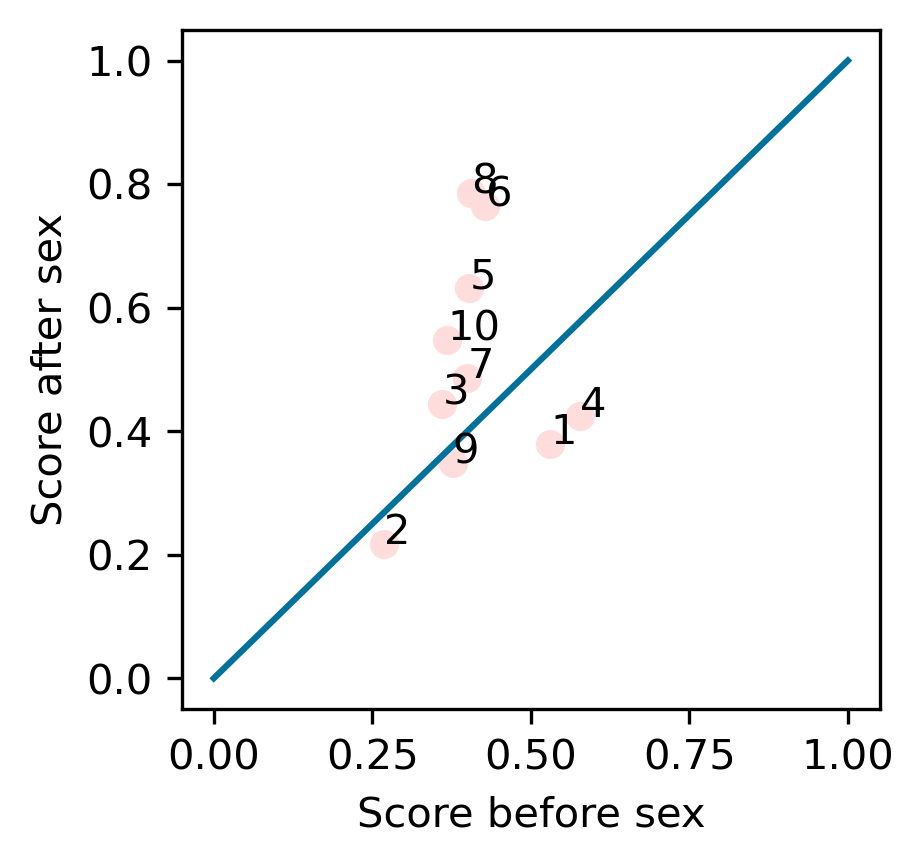

In [31]:
DVPP = DVP.join(DV[['participant']]).pivot(index='participant', columns='experiment', values='1')

DVPP

fig, axes = biu.utils.figure.subplots(figsize=(3,3))
plt.scatter(DVPP['No Sex'], DVPP['Sex'], c=pink)
for p in DVPP.index:
    x,y = DVPP.loc[p]
    plt.text(x,y, str(p))
plt.plot([0,1],[0,1], c=blue)
#plt.plot([0,1],[0.5,0.5])
plt.xlabel('Score before sex')
plt.ylabel('Score after sex')
fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_prediction_delta_vagina','svg'))

### Underwear

In [32]:
RA_clr = RA.apply(lambda x: np.log(x) - np.log(scipy.stats.gmean(x)), axis=1)
S_usex = S[(S.condition == 'Underwear') & S.Day.isin([1,2,4,5])]
DU = pd.concat([
    pd.DataFrame([ [p,'Sex'] + list((RA_clr.loc[s[2]] - RA_clr.loc[s[1]]).values)
     for (p, s) in S_usex.reset_index().pivot(index='participant',columns='Day', values='sample').iterrows()]),
    pd.DataFrame([ [p,'No Sex'] + list((RA_clr.loc[s[5]] - RA_clr.loc[s[4]]).values)
     for (p, s) in S_usex.reset_index().pivot(index='participant',columns='Day', values='sample').iterrows()])])

DU.columns = ['participant','experiment'] + list(RA.columns)
DU.index   = [ 'CLRS_%d' % (i+1) for i in range(len(DU.index)) ]

DUP = lopo(list(RA.columns), 'experiment', DU, 'participant')

                1 experiment
CLRS_1   0.467266        Sex
CLRS_11  0.415640     No Sex
                1 experiment
CLRS_2   0.482120        Sex
CLRS_12  0.446542     No Sex
                1 experiment
CLRS_3   0.256336        Sex
CLRS_13  0.350149     No Sex
                1 experiment
CLRS_4   0.326935        Sex
CLRS_14  0.423104     No Sex
                1 experiment
CLRS_5   0.566672        Sex
CLRS_15  0.534939     No Sex
           1 experiment
CLRS_6   0.5        Sex
CLRS_16  0.5     No Sex
                1 experiment
CLRS_7   0.497311        Sex
CLRS_17  0.506123     No Sex
           1 experiment
CLRS_8   0.5        Sex
CLRS_18  0.5     No Sex
           1 experiment
CLRS_9   0.5        Sex
CLRS_19  0.5     No Sex
                1 experiment
CLRS_10  0.756258        Sex
CLRS_20  0.623253     No Sex


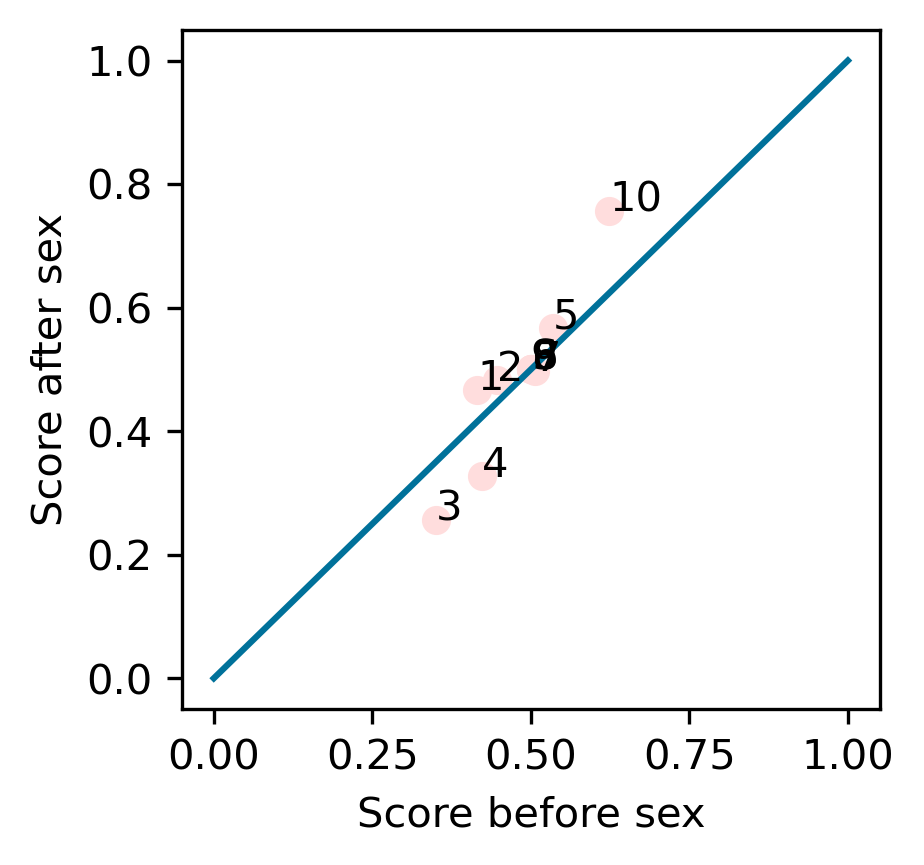

In [33]:
DUPP = DUP.join(DU[['participant']]).pivot(index='participant', columns='experiment', values='1')

fig, axes = biu.utils.figure.subplots(figsize=(3,3))
plt.scatter(DUPP['No Sex'], DUPP['Sex'], c=pink)
for p in DUPP.index:
    x,y = DUPP.loc[p]
    plt.text(x,y, str(p))
plt.plot([0,1],[0,1], c=blue)
#plt.plot([0,1],[0.5,0.5])
plt.xlabel('Score before sex')
plt.ylabel('Score after sex')
fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_prediction_delta_underwear','svg'))

## Normal model

### Vagina

In [61]:
S_vsex = S[(S.condition == 'Vaginal FLOQSwab') & S.Day.isin([1,2])]
S_vsex = S_vsex[['participant','experiment']]
S_vsex = S_vsex.join(RA.loc[S_vsex.index].apply(lambda x: np.log(x) - np.log(scipy.stats.gmean(x)), axis=1))
PV = lopo(list(RA.columns), 'experiment', S_vsex, 'participant')

             1 experiment
S108  0.493725     No sex
S118  0.549286        Sex
             1 experiment
S109  0.496596     No sex
S119  0.485824        Sex
             1 experiment
S110  0.304708     No sex
S120  0.406326        Sex
             1 experiment
S111  0.207124     No sex
S121  0.322444        Sex
             1 experiment
S112  0.266821     No sex
S122  0.863940        Sex
             1 experiment
S113  0.323389     No sex
S123  0.566976        Sex
             1 experiment
S114  0.336525     No sex
S124  0.370500        Sex
             1 experiment
S115  0.354329     No sex
S125  0.873612        Sex
             1 experiment
S116  0.127646     No sex
S126  0.083474        Sex
        1 experiment
S117  0.5     No sex
S127  0.5        Sex


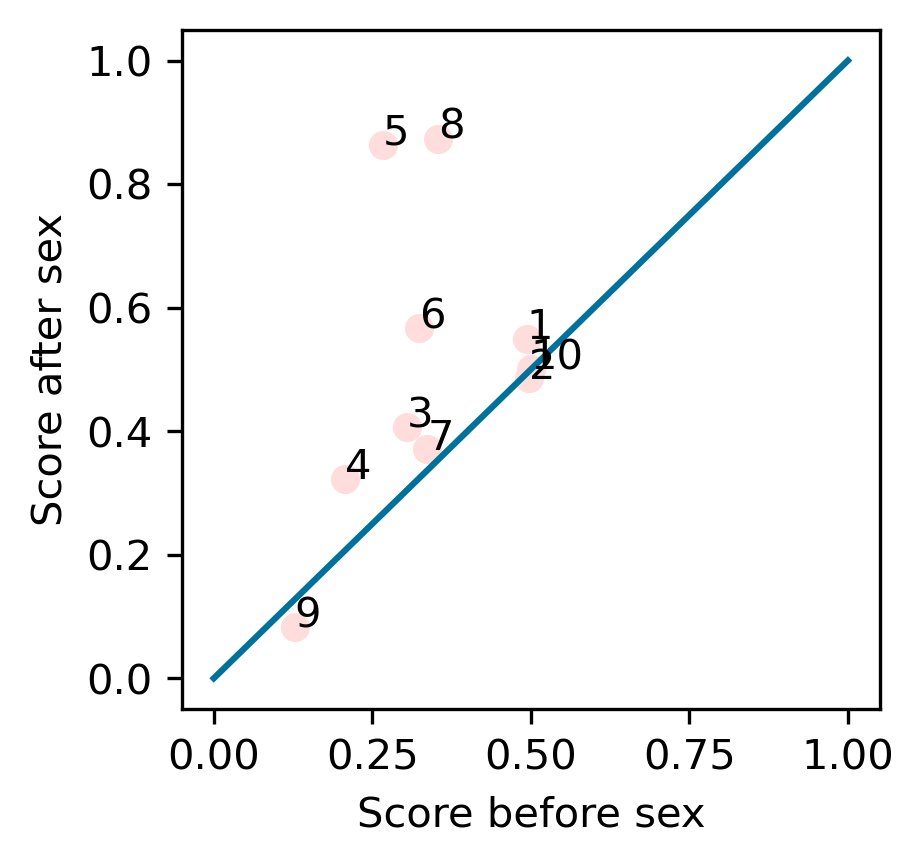

In [81]:
fig, axes = biu.utils.figure.subplots(figsize=(3,3))
PTV = PV.join(S[['participant']]).pivot(index='participant', columns='experiment', values='1')

plt.scatter(PTV['No sex'], PTV['Sex'], c=pink)
for p in PTV.index:
    x,y = PTV.loc[p]
    plt.text(x,y, str(p))
#efor
plt.plot([0,1],[0,1], c=blue)
#plt.plot([0,1],[0.5,0.5])
plt.xlabel('Score before sex')
plt.ylabel('Score after sex')
fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_prediction_vagina','svg'))

### Underwear

In [65]:
S_usex = S[(S.condition == 'Underwear') & S.Day.isin([1,2])]
S_usex = S_usex[['participant','experiment']]
S_usex = S_usex.join(RA.loc[S_usex.index].apply(lambda x: np.log(x) - np.log(scipy.stats.gmean(x)), axis=1))
PU = lopo(list(RA.columns), 'experiment', S_usex, 'participant')

        1 experiment
S290  0.5     No sex
S300  0.5        Sex
        1 experiment
S291  0.5     No sex
S301  0.5        Sex
        1 experiment
S292  0.5     No sex
S302  0.5        Sex
        1 experiment
S293  0.5     No sex
S303  0.5        Sex
        1 experiment
S294  0.5     No sex
S304  0.5        Sex
        1 experiment
S295  0.5     No sex
S305  0.5        Sex
        1 experiment
S296  0.5     No sex
S306  0.5        Sex
        1 experiment
S297  0.5     No sex
S307  0.5        Sex
        1 experiment
S298  0.5     No sex
S308  0.5        Sex
        1 experiment
S299  0.5     No sex
S309  0.5        Sex


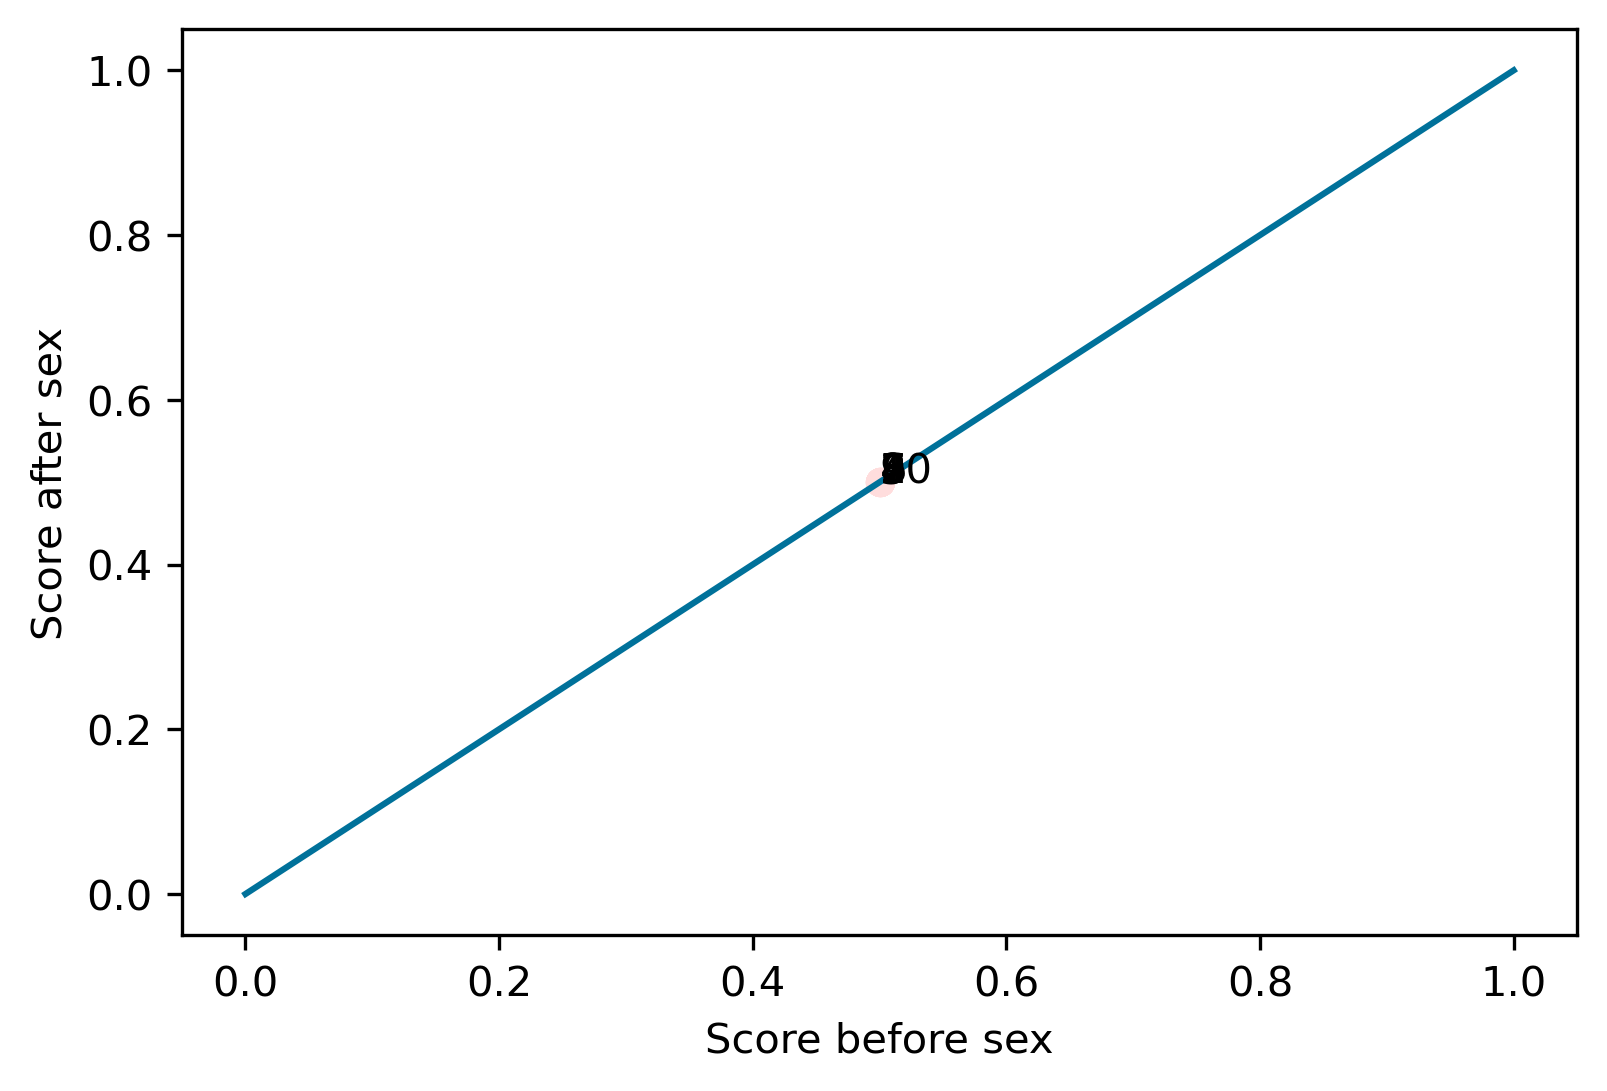

In [82]:
fig, axes = biu.utils.figure.subplots()
PTU = PU.join(S[['participant']]).pivot(index='participant', columns='experiment', values='1')

plt.scatter(PTU['No sex'], PTU['Sex'], c=pink)
plt.plot([0,1],[0,1], c=blue)
for p in PTU.index:
    x,y = PTU.loc[p]
    plt.text(x,y, str(p))
#efor
#plt.plot([0,1],[0.5,0.5])
plt.xlabel('Score before sex')
plt.ylabel('Score after sex')
fig.savefig(biu.utils.fs.filename_today('paper_figures/asv_prediction_underwear','svg'))

## In Isala

See `~/repos/UA_isala/predict_intercourse.ipynb`

# Seminal data

In [7]:
zurich_semen = pd.read_csv('data/seminal/seqtab_nochim_se_V3V5.csv',index_col=0)
semen_asvs = zurich_semen.columns

T['semen_match'] = T.taxon.apply(lambda t: [ x for x in semen_asvs if t in x ])
T['n_semen_match'] = T.semen_match.apply(lambda x: len(x))

T[T.n_semen_match > 0].to_excel(biu.utils.fs.filename_today('paper_figures/semen_isala_asv_matches','xlsx'))
T[T.n_semen_match > 0]#.sort_values('n_semen_match').taxon_id

kingdom          phylum                  class              order  \
1    Bacteria      Firmicutes                Bacilli    Lactobacillales   
2    Bacteria      Firmicutes                Bacilli    Lactobacillales   
3    Bacteria      Firmicutes                Bacilli         Bacillales   
9    Bacteria  Actinobacteria       Actinobacteria_c  Corynebacteriales   
14   Bacteria      Firmicutes           Tissierellia     Tissierellales   
22   Bacteria   Bacteroidetes            Bacteroidia      Bacteroidales   
26   Bacteria      Firmicutes           Tissierellia     Tissierellales   
33   Bacteria      Firmicutes           Tissierellia     Tissierellales   
37   Bacteria   Bacteroidetes            Bacteroidia      Bacteroidales   
47   Bacteria      Firmicutes          Negativicutes     Veillonellales   
52   Bacteria  Proteobacteria    Gammaproteobacteria    Pseudomonadales   
53   Bacteria      Firmicutes           Tissierellia     Tissierellales   
54   Bacteria      Firmicutes                Bacilli    Lactobacillales   
61   Bacteria   Bacteroidetes            Bacteroidia      Bacteroidales   
64   Bacteria      Firmicutes                Bacilli    Lactobacillales   
67   Bacteria      Firmicutes           Tissierellia     Tissierellales   
70   Bacteria  Proteobacteria    Gammaproteobacteria  Enterobacteriales   
73   Bacteria  Actinobacteria         Coriobacteriia   Coriobacteriales   
81   Bacteria      Firmicutes           Tissierellia     Tissierellales   
85   Bacteria  Actinobacteria       Actinobacteria_c  Corynebacteriales   
87   Bacteria  Actinobacteria       Actinobacteria_c      Micrococcales   
99   Bacteria      Firmicutes           Tissierellia     Tissierellales   
112  Bacteria      Firmicutes           Tissierellia     Tissierellales   
113  Bacteria      Firmicutes           Tissierellia     Tissierellales   
115  Bacteria  Actinobacteria       Actinobacteria_c    Actinomycetales   
120  Bacteria      Firmicutes                Bacilli    Lactobacillales   
122  Bacteria      Firmicutes          Negativicutes     Veillonellales   
125  Bacteria      Firmicutes           Tissierellia     Tissierellales   
128  Bacteria  Actinobacteria       Actinobacteria_c  Corynebacteriales   
142  Bacteria      Firmicutes           Tissierellia     Tissierellales   
156  Bacteria  Proteobacteria  Epsilonproteobacteria  Campylobacterales   
159  Bacteria  Actinobacteria       Actinobacteria_c  Corynebacteriales   
180  Bacteria   Bacteroidetes            Bacteroidia      Bacteroidales   
187  Bacteria   Bacteroidetes            Bacteroidia      Bacteroidales   
205  Bacteria      Firmicutes           Tissierellia     Tissierellales   
228  Bacteria  Actinobacteria       Actinobacteria_c    Actinomycetales   
276  Bacteria      Firmicutes             Clostridia      Clostridiales   
285  Bacteria   Bacteroidetes            Bacteroidia      Bacteroidales   
301  Bacteria  Proteobacteria    Alphaproteobacteria    Rhodobacterales   
305  Bacteria      Firmicutes                Bacilli    Lactobacillales   
321  Bacteria  Actinobacteria       Actinobacteria_c    Actinomycetales   
325  Bacteria  Actinobacteria       Actinobacteria_c    Actinomycetales   
334  Bacteria  Actinobacteria       Actinobacteria_c  Corynebacteriales   
364  Bacteria      Firmicutes           Tissierellia     Tissierellales   
437  Bacteria      Firmicutes          Negativicutes     Veillonellales   
473  Bacteria      Firmicutes             Clostridia      Clostridiales   
562  Bacteria      Firmicutes          Negativicutes     Veillonellales   
719  Bacteria      Firmicutes             Clostridia      Clostridiales   
954  Bacteria   Bacteroidetes            Bacteroidia      Bacteroidales   

                 family                          genus  \
1      Lactobacillaceae      Lactobacillus iners group   
2      Lactobacillaceae  Lactobacillus crispatus group   
3     Staphylococcaceae                 Staphylococcus   
9    Corynebacteriaceae